# 0.0 Imports

In [1]:
import datetime
import inflection
import math
import numpy as np
import pandas as pd
import pickle
import requests
import random
import seaborn as sns
import xgboost

from boruta                import BorutaPy
from IPython.display       import Image
from matplotlib            import pyplot as plt
from matplotlib            import gridspec as gs
from numpy                 import int64
from scipy                 import stats as ss
from tabulate              import tabulate

from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder 
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso

## 0.1 Helper Functions

In [2]:
def cramer_v(x, y):

    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    
    phi2corr = max(0, chi2/n - ((k-1)*(r-1)/(n-1)))
    kcorr = k - ((k-1)**2/(n-1))
    rcorr = r - ((r-1)**2/(n-1))
    
    return np.sqrt( (phi2corr)/ ( min(kcorr-1,rcorr-1) ) )

def ml_error(model_name, y, yhat):
    
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name, 
                         'MAE': mae, 
                         'MAPE': mape, 
                         'RMSE': rmse}, index=[0])


def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list = list()
    mape_list = list()
    rmse_list = list()
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
            
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering date
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <=validation_end_date)]


        # training dataset
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation dataset
        xvalidation = validation.drop(['date' ,'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # predicition
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name, 
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str), 
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str) }, index = [0])

def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = (25,12)
    plt.rcParams['font.size'] = 24
    
    #display(HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='inner', on='Store')

# 1.0. Passo 01 - Descrição dos Dados


## 1.1. Rename Columns

In [4]:
df1 = df_raw.copy()

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 
            'Sales', 'Customers', 'Open', 
            'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance',    
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimension

In [6]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Coluns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Coluns: 18


## 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. FillOut NA

In [9]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                              
# promo2_since_week    
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year   
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval                  
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 
                                           if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6. Change Types

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int64)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int64)

## 1.7. Descriptive Statistical

### 1.7.1 Numerical Attributed

In [11]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [12]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concataneate

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

### 1.7.2. Categorical Attributes

In [13]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

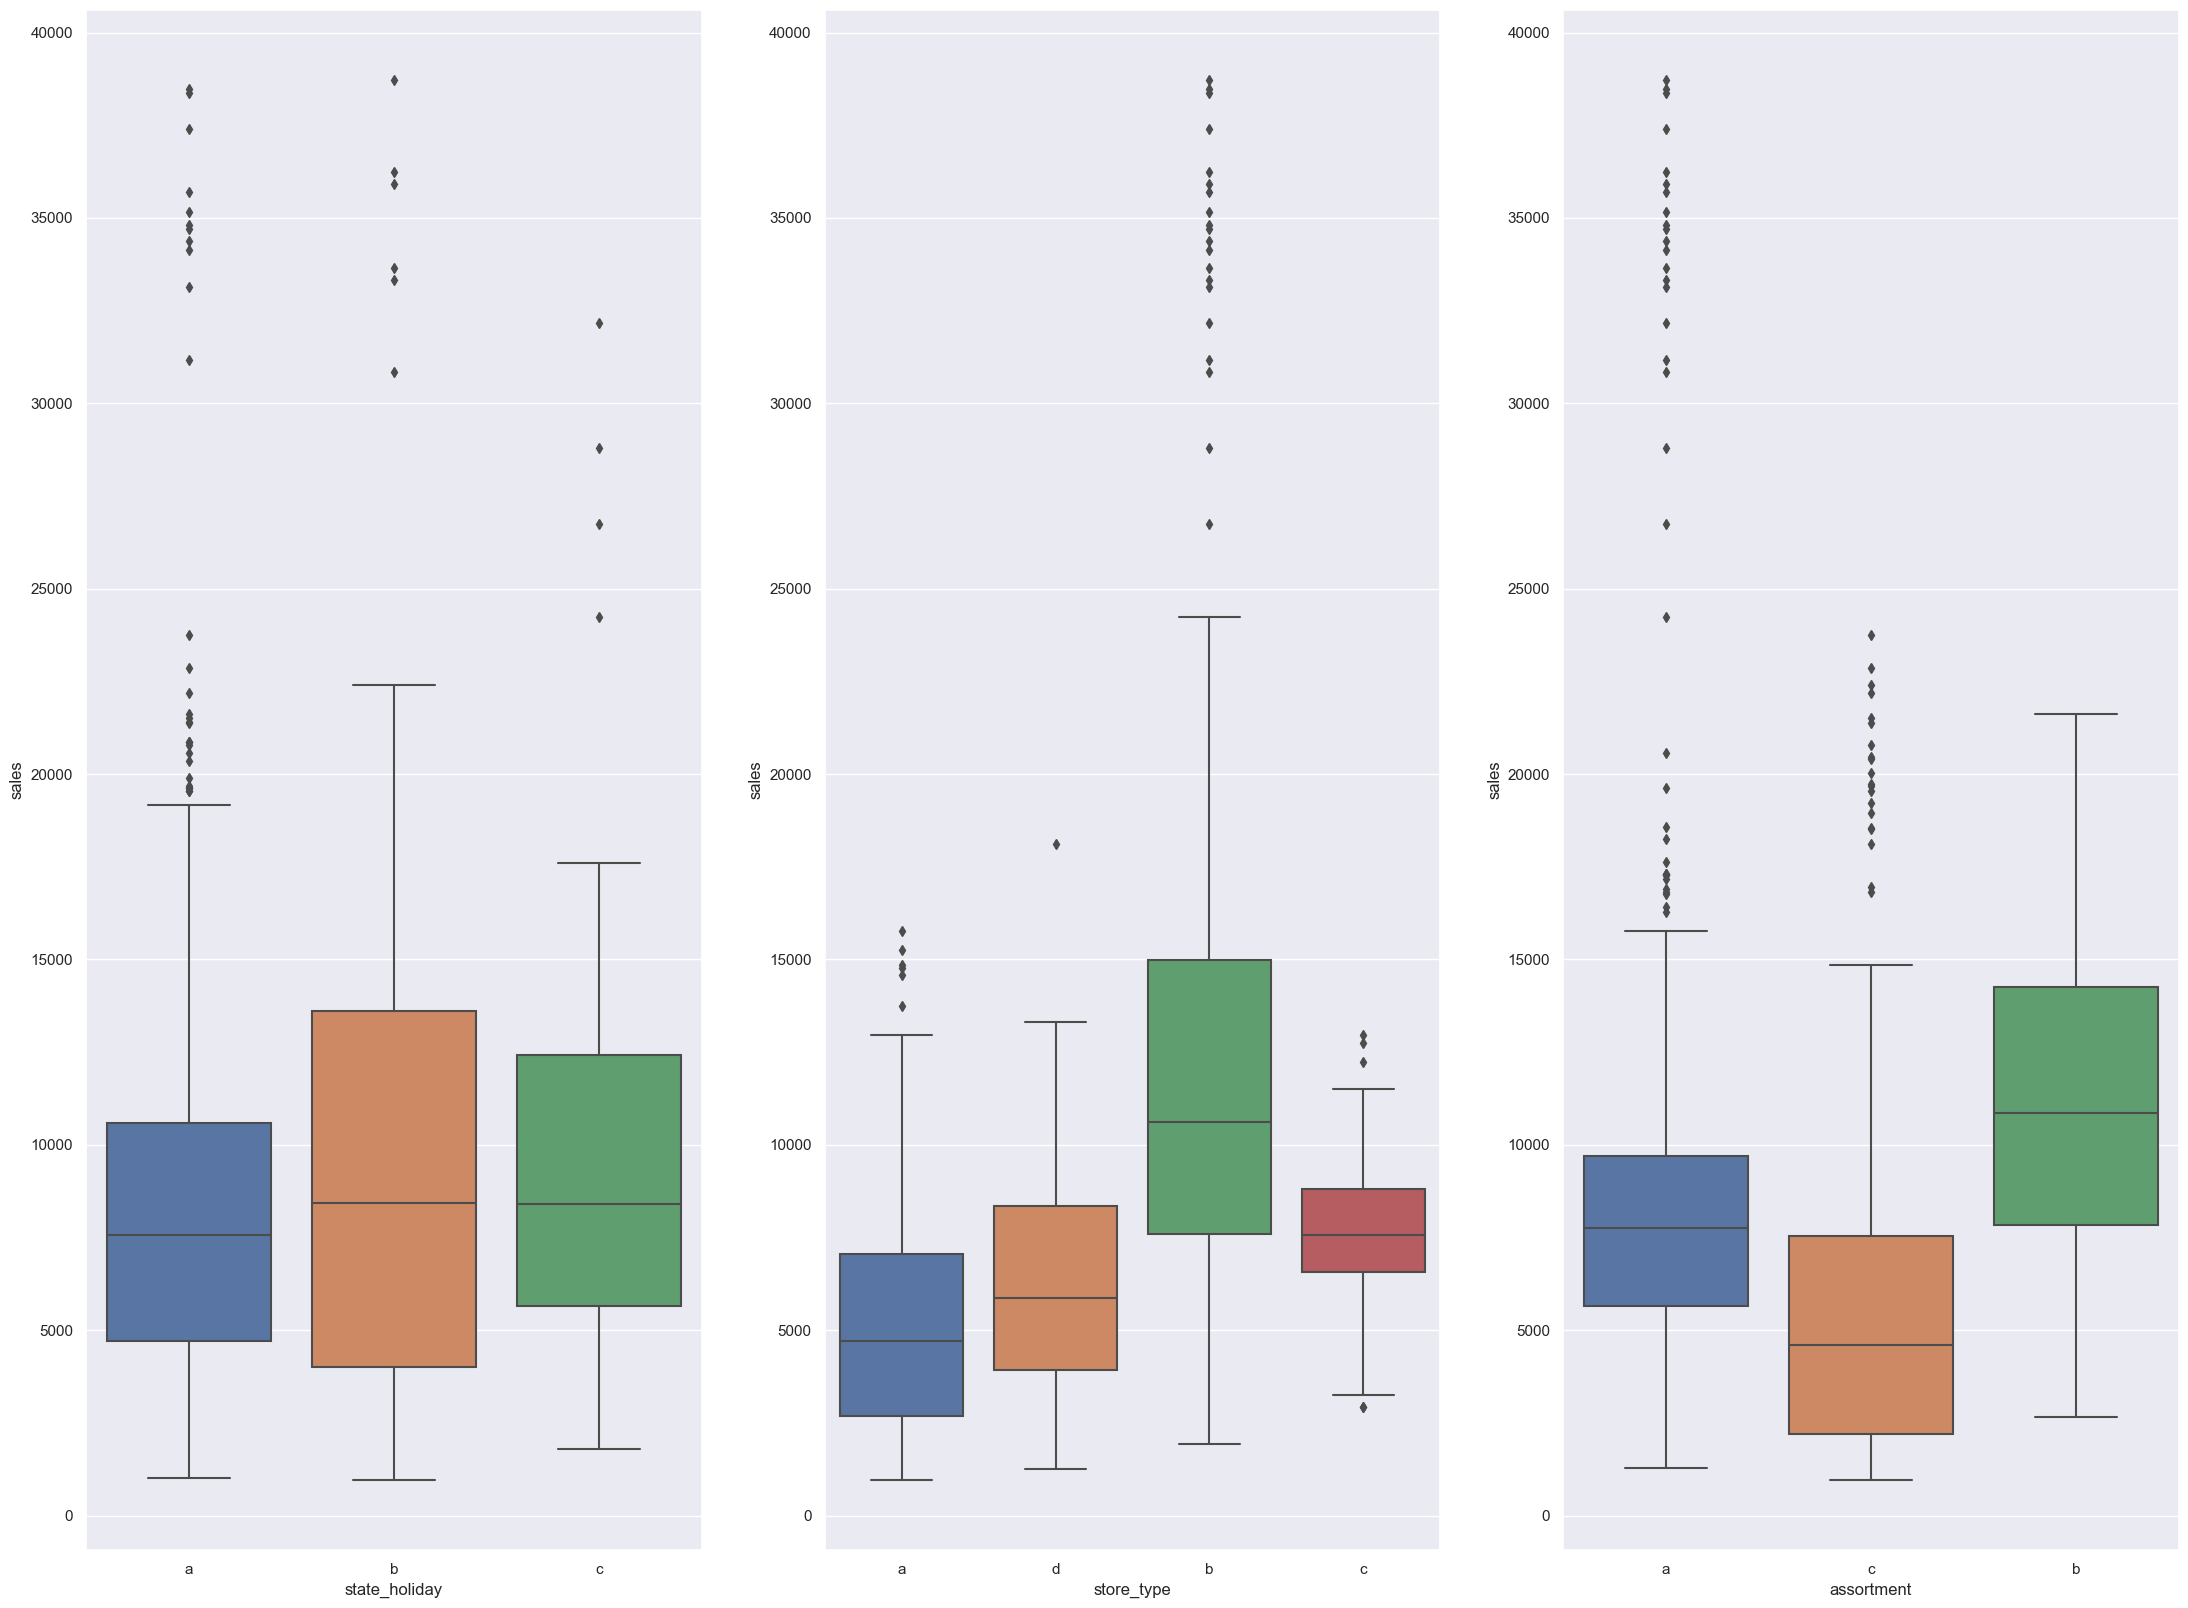

In [14]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(27,20))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1);

# 2.0. Passo 02 - Feature Engineering

In [15]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

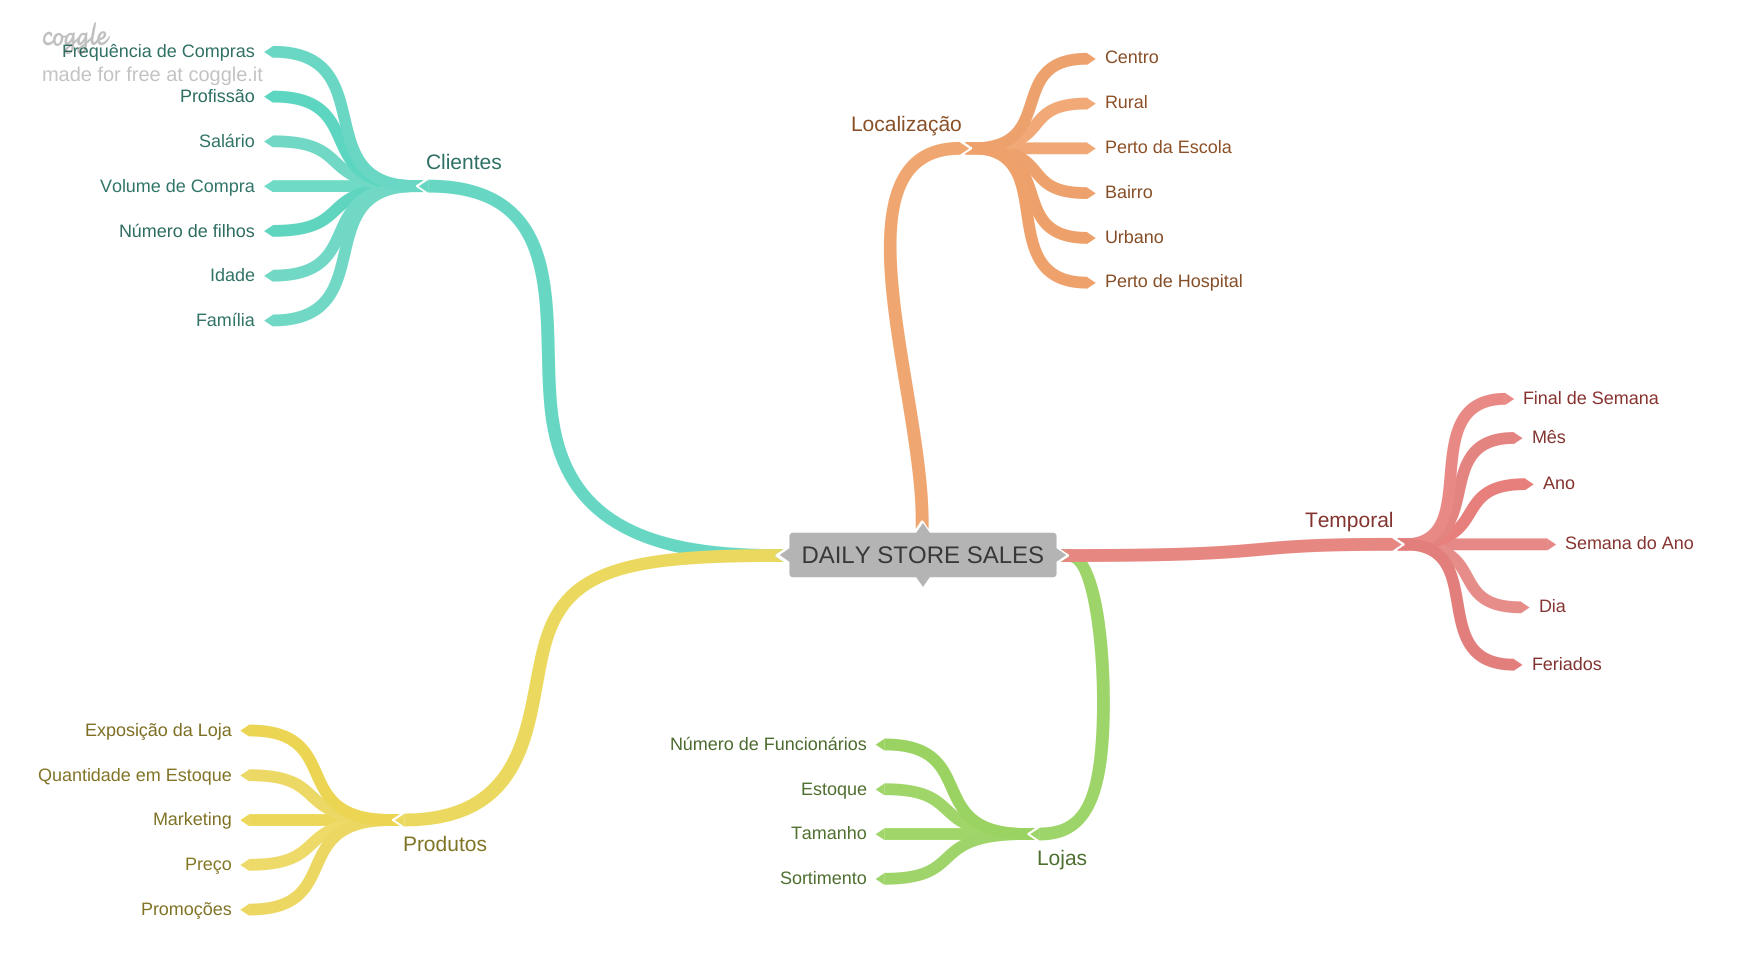

In [16]:
Image('img/mind_map_hypothesis.png')

## 2.2. Criação de Hipóteses

### 2.2.1. Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõem mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas(descontos maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

### 2.2.3 Hipóteses Temporal

**1.** Lojas abertas durante o feriado de Natal deeriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semetre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais dias de promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semetre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature Engineering

In [17]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x : datetime.datetime(year = x['competition_open_since_year'], 
                             month=x['competition_open_since_month'], 
                             day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int64)

# promo since
df2['promo_since'] = df2.apply(lambda x: str(x['promo2_since_year']) + '-' + str(x['promo2_since_week']), axis=1)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'extra' 
                                                  if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. Passo 03 - Filtragem de Variáveis

In [18]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [19]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [20]:
cols_drop =  ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Passo 04 - Análise Exploratória dos Dados

In [21]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variavel

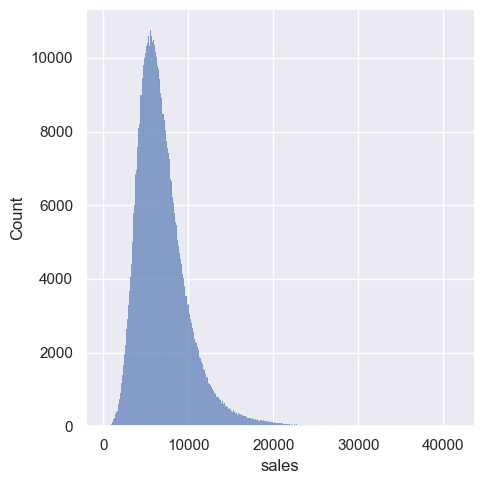

In [22]:
sns.displot(df4['sales']);

### 4.1.2. Numerical Attributtes

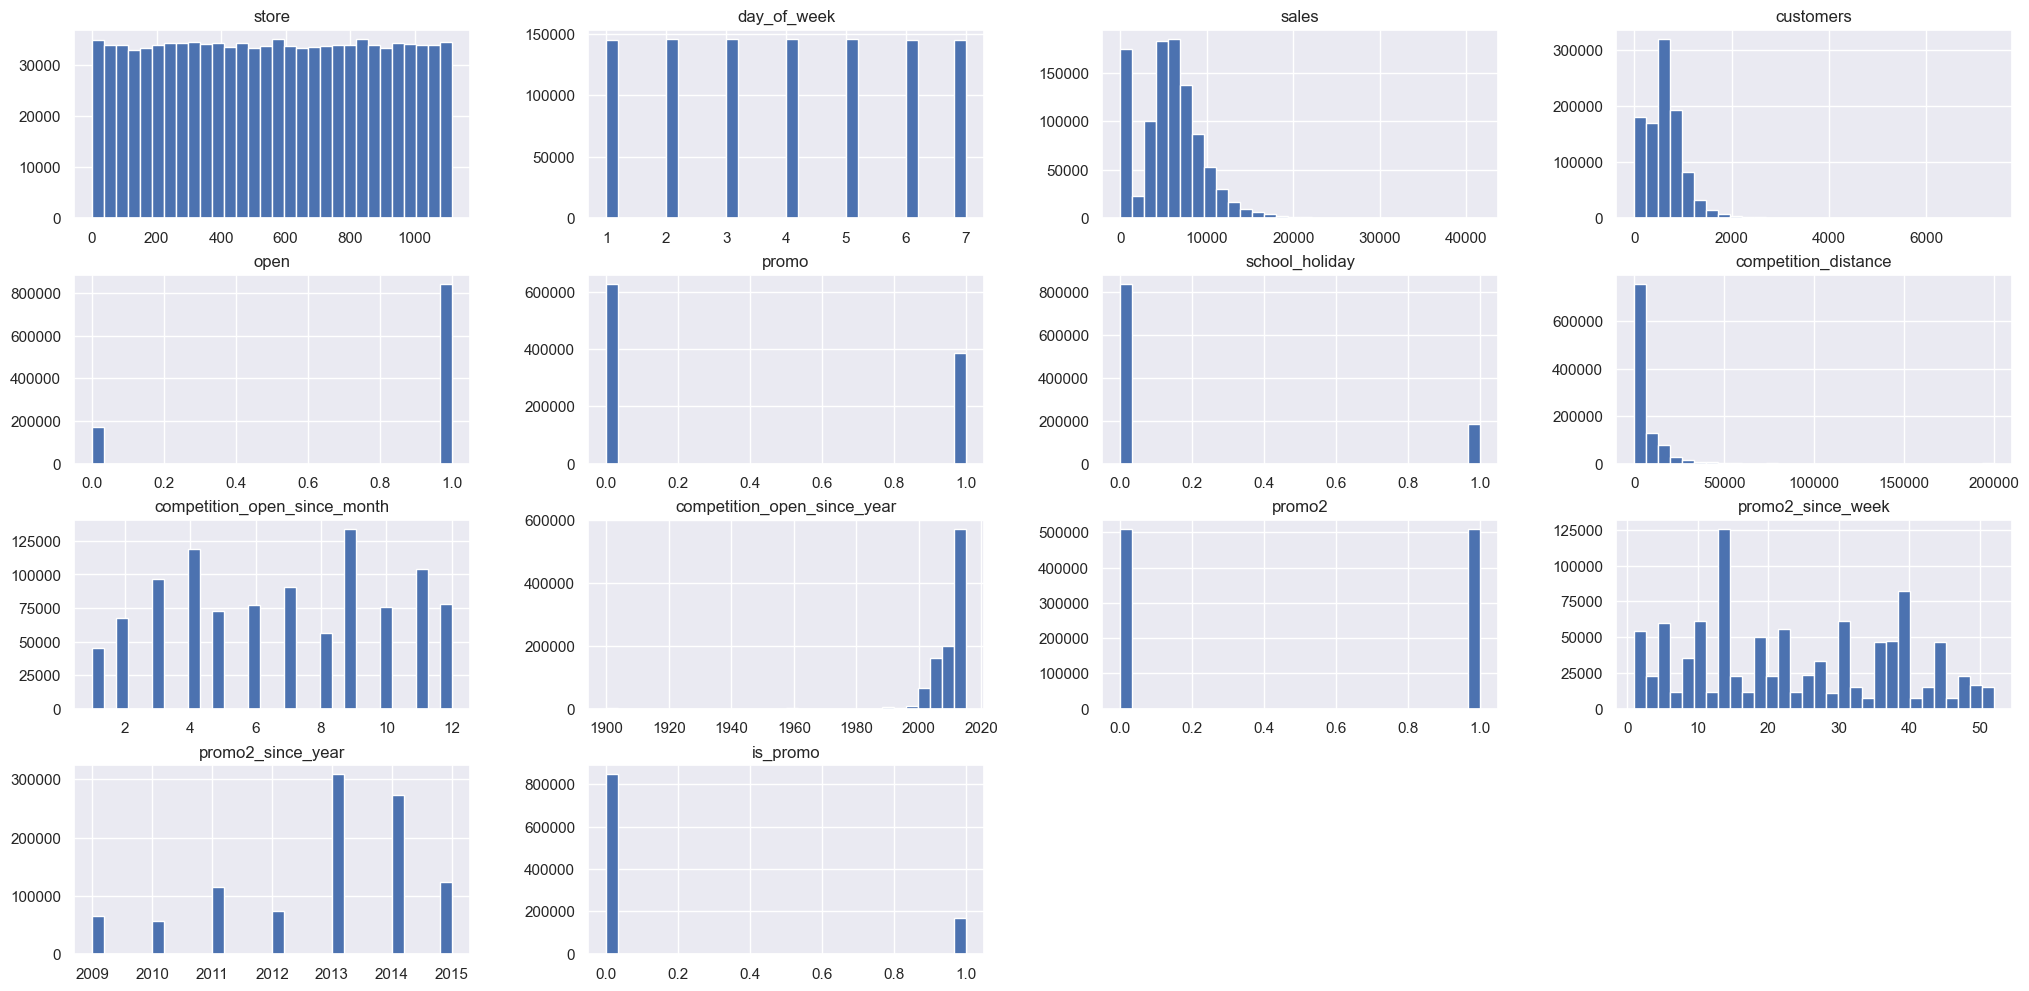

In [23]:
num_attributes.hist(bins=30);

### 4.1.3 Categorical Variable

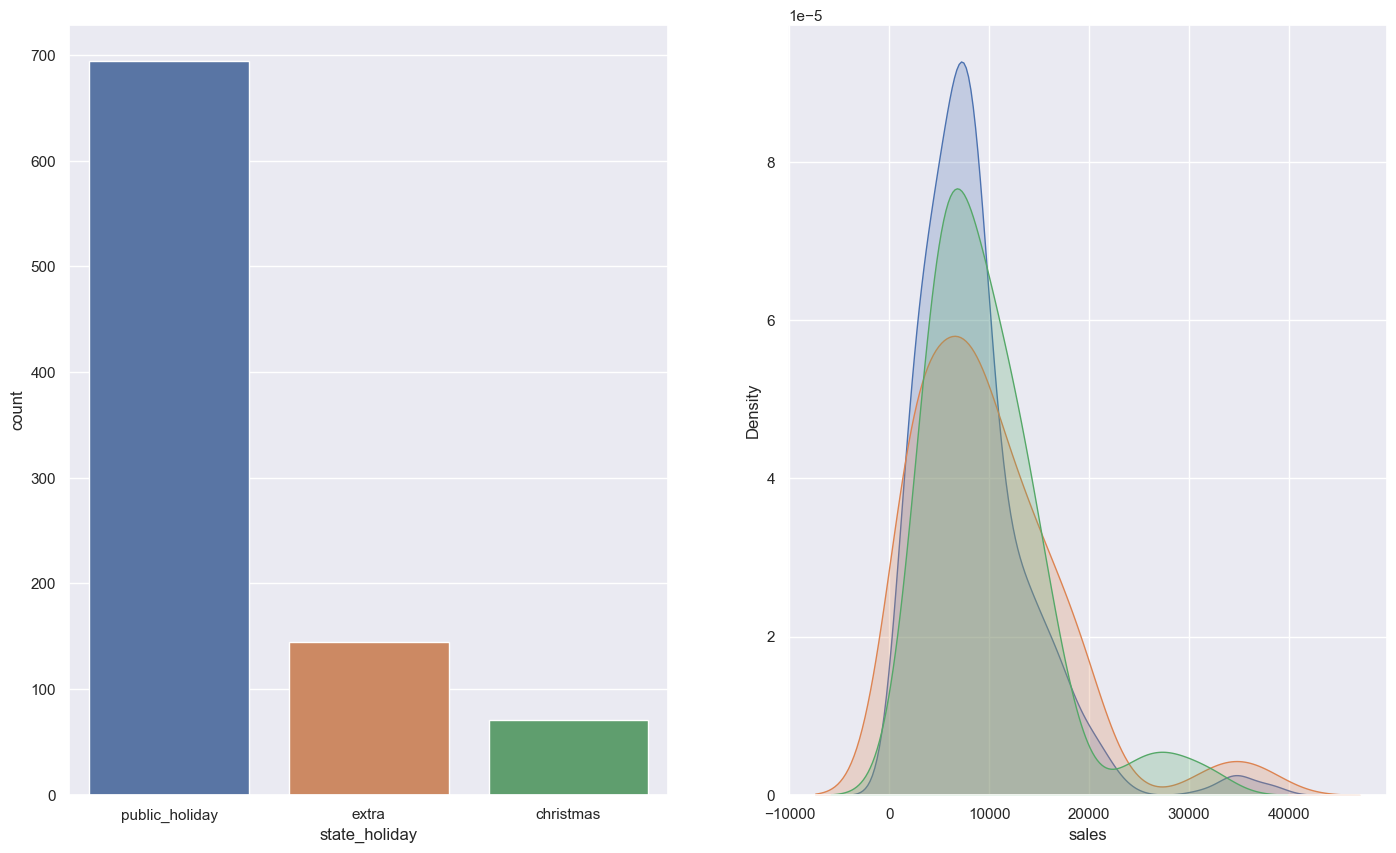

In [24]:
# state holiday
plt.figure(figsize=(17,10))
plt.subplot(1,2,1)
sns.countplot(x=df4[df4['state_holiday'] != 'regular_day']['state_holiday'] )

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True);
sns.kdeplot(df4[df4['state_holiday'] == 'extra']['sales'], label='extra', fill=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True);

<AxesSubplot:xlabel='sales', ylabel='Density'>

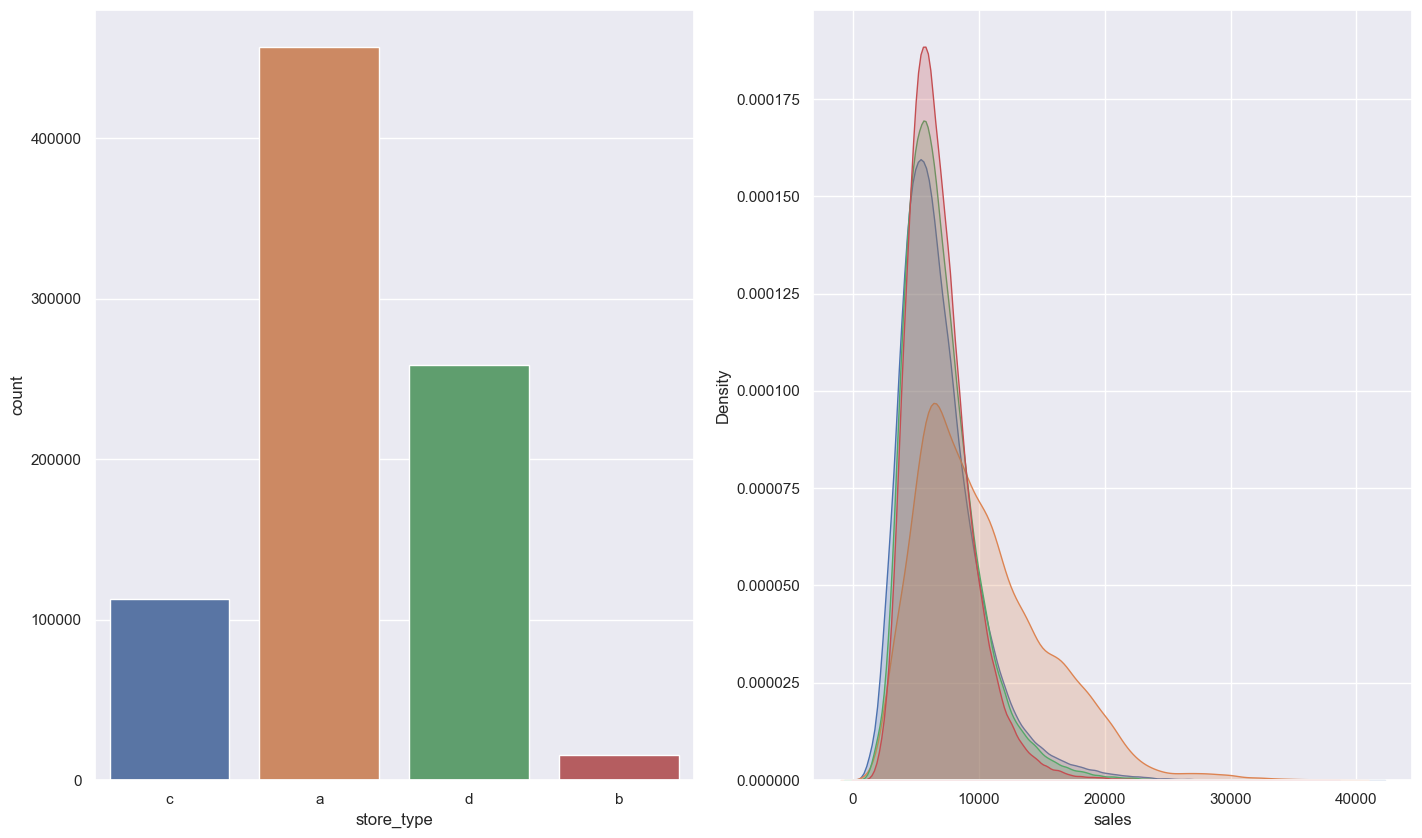

In [25]:
# store_type

plt.figure(figsize=(17,10))
plt.subplot(1,2,1)
sns.countplot(x=df4['store_type'])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='c', fill=True)

<AxesSubplot:xlabel='sales', ylabel='Density'>

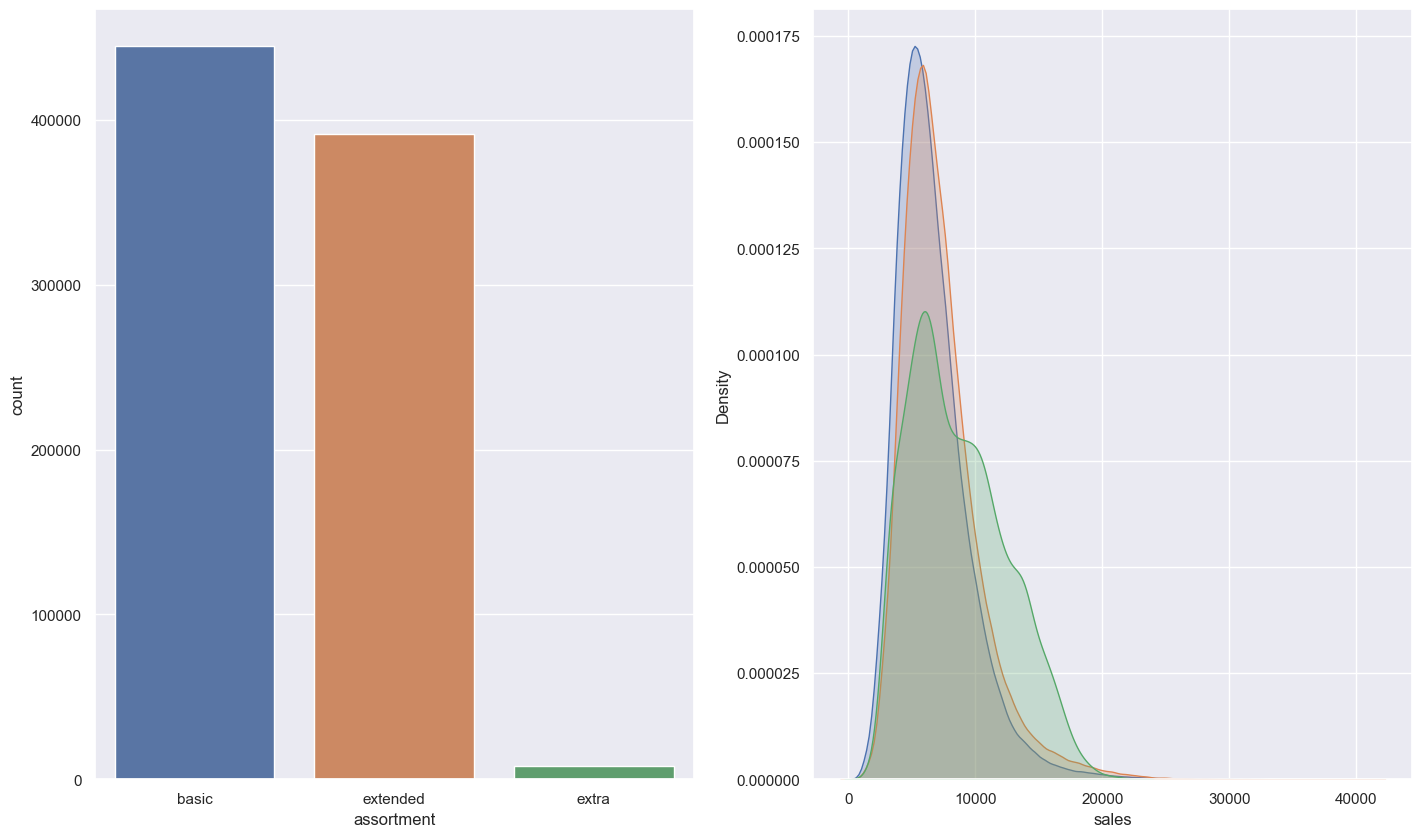

In [26]:
# assortment
plt.figure(figsize=(17,10))
plt.subplot(1,2,1)
sns.countplot(x=df4['assortment'])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)

## 4.2. Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

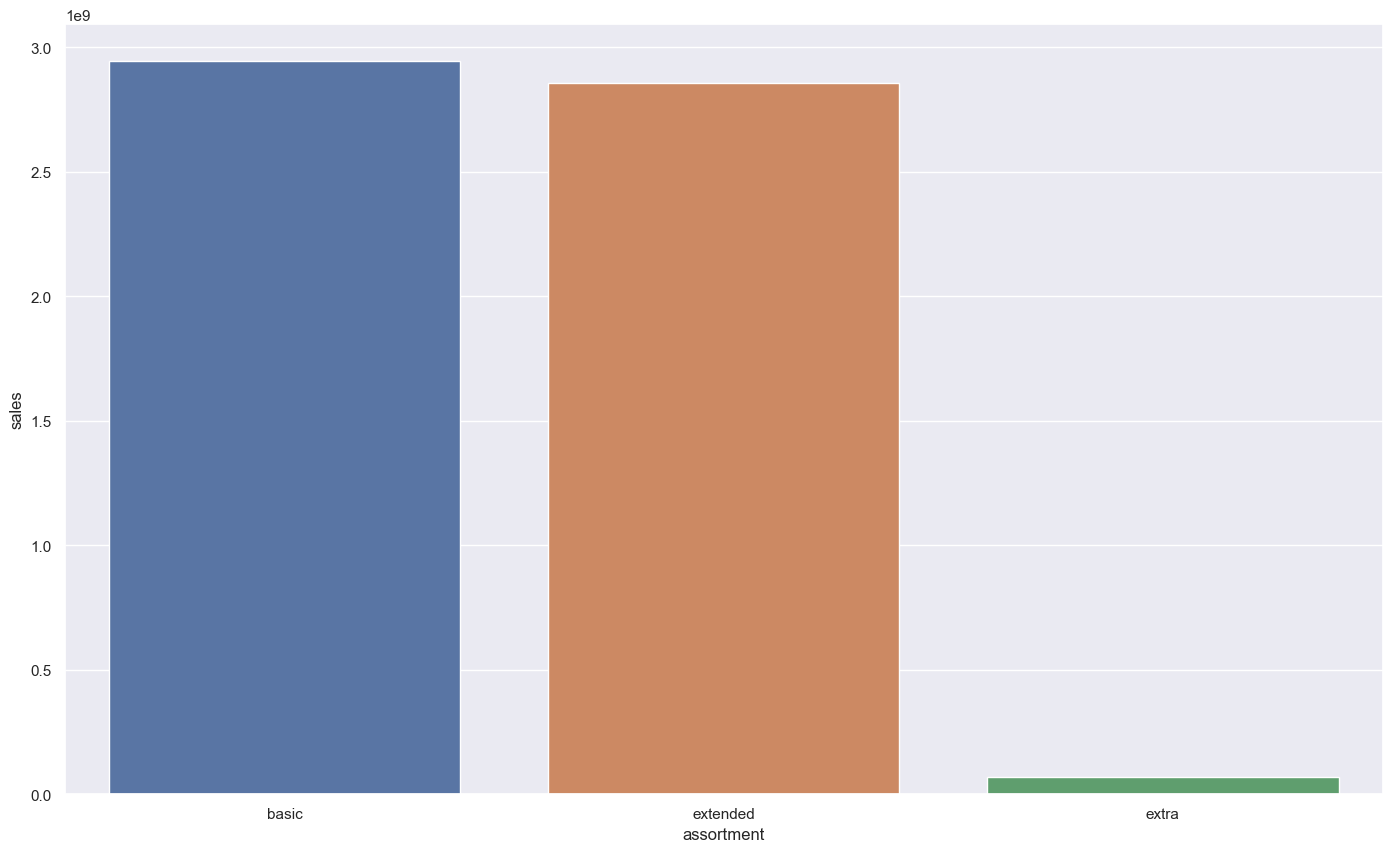

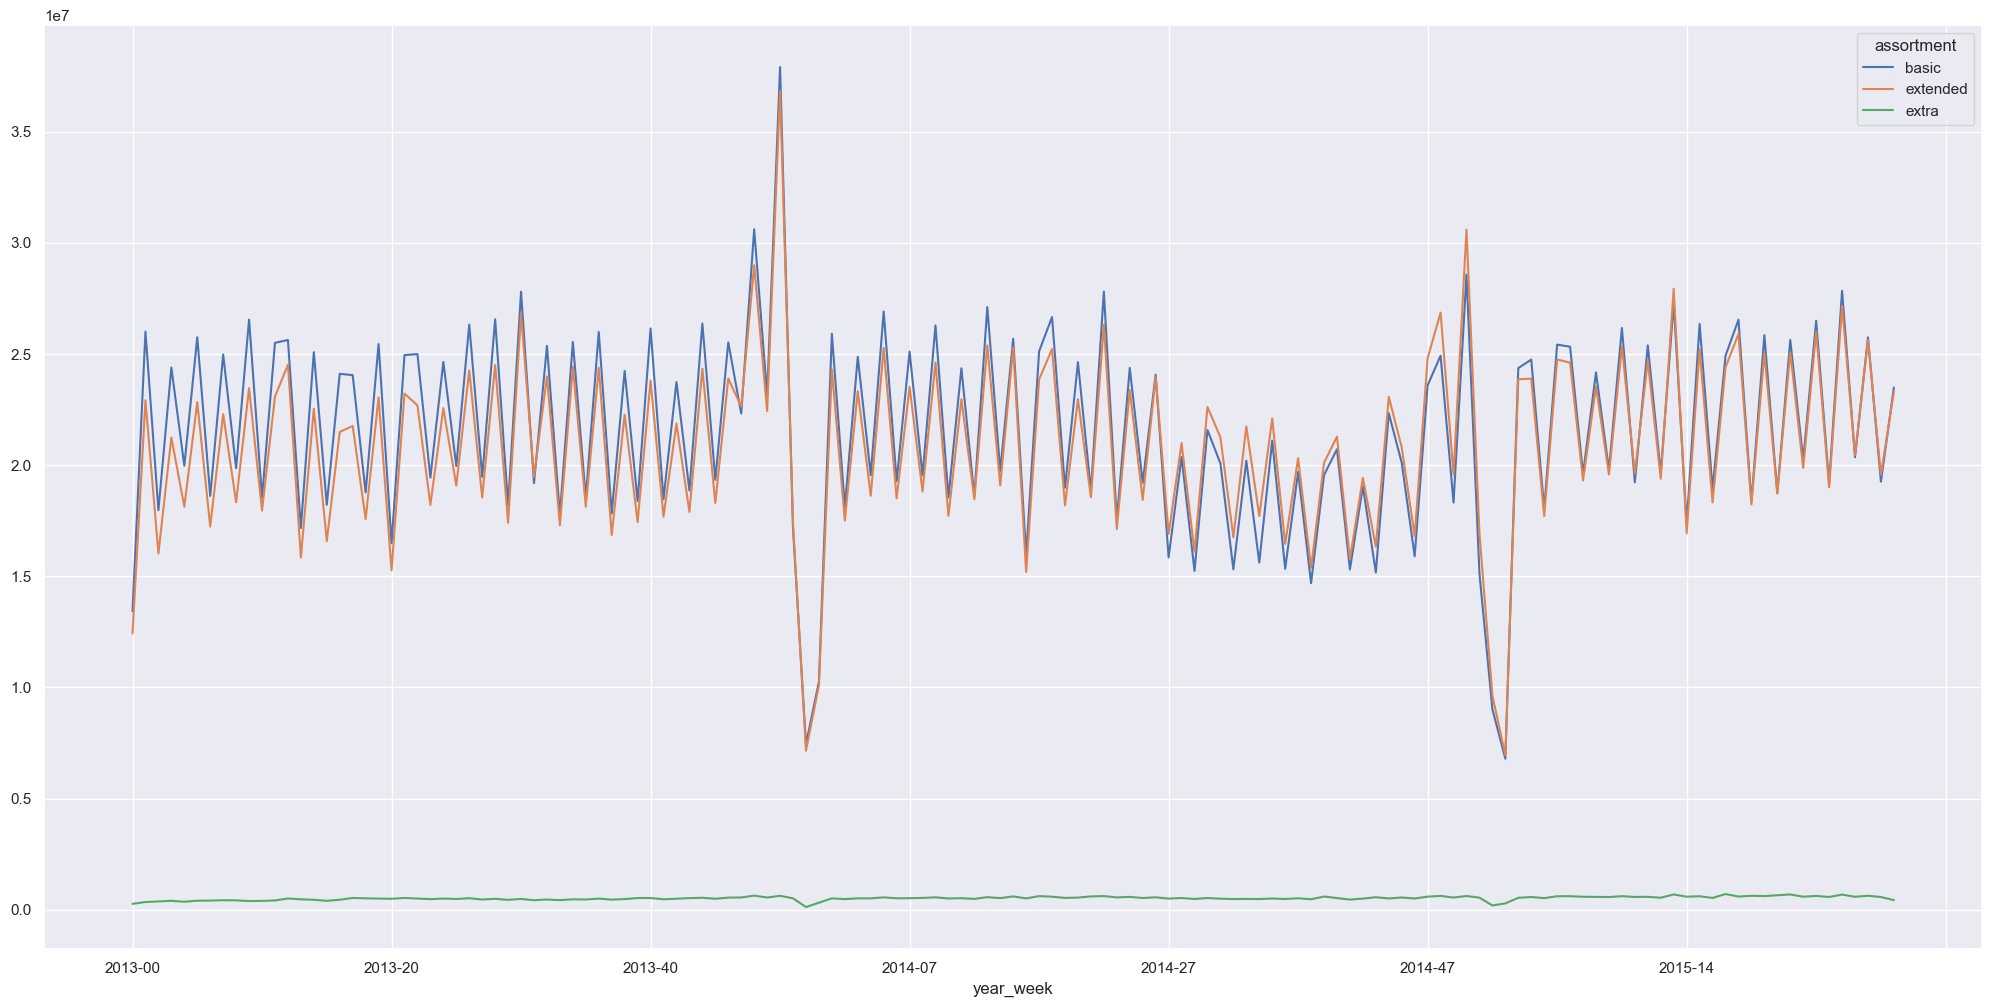

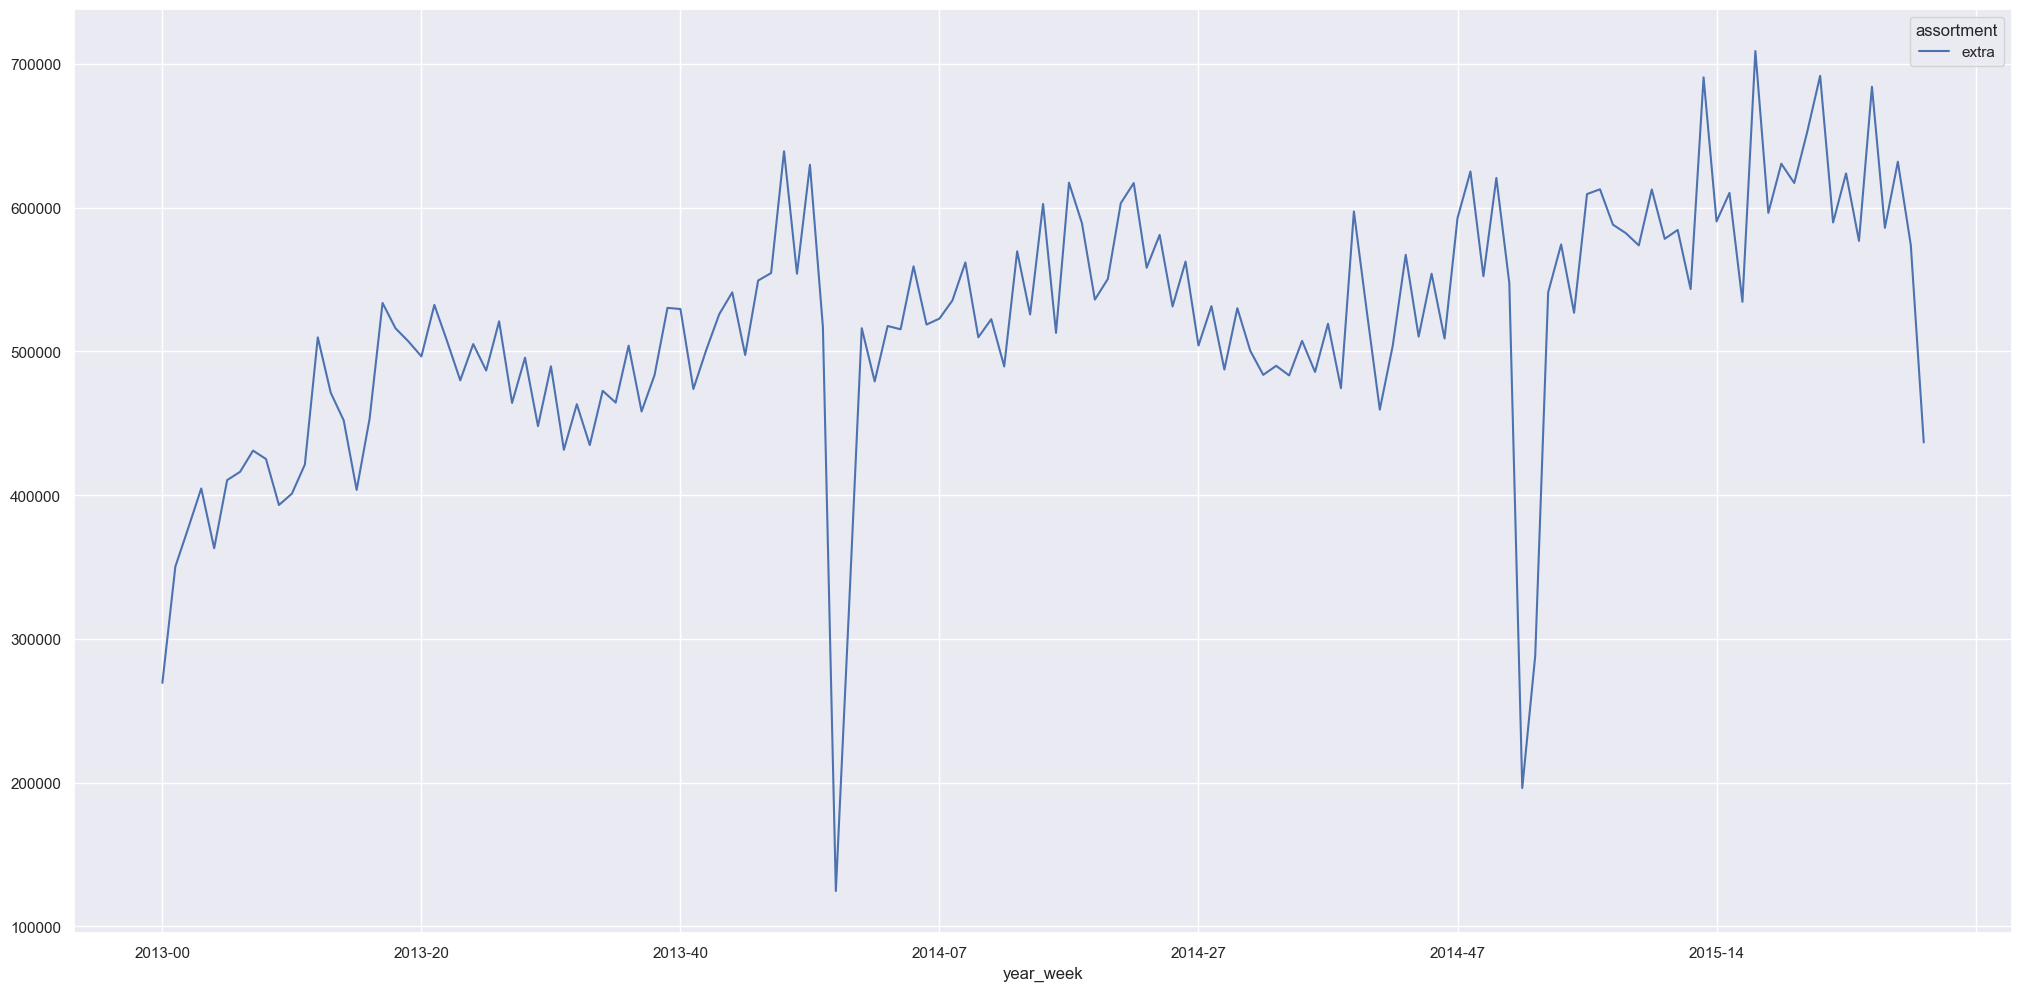

In [27]:
plt.figure(figsize=(17,10))
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

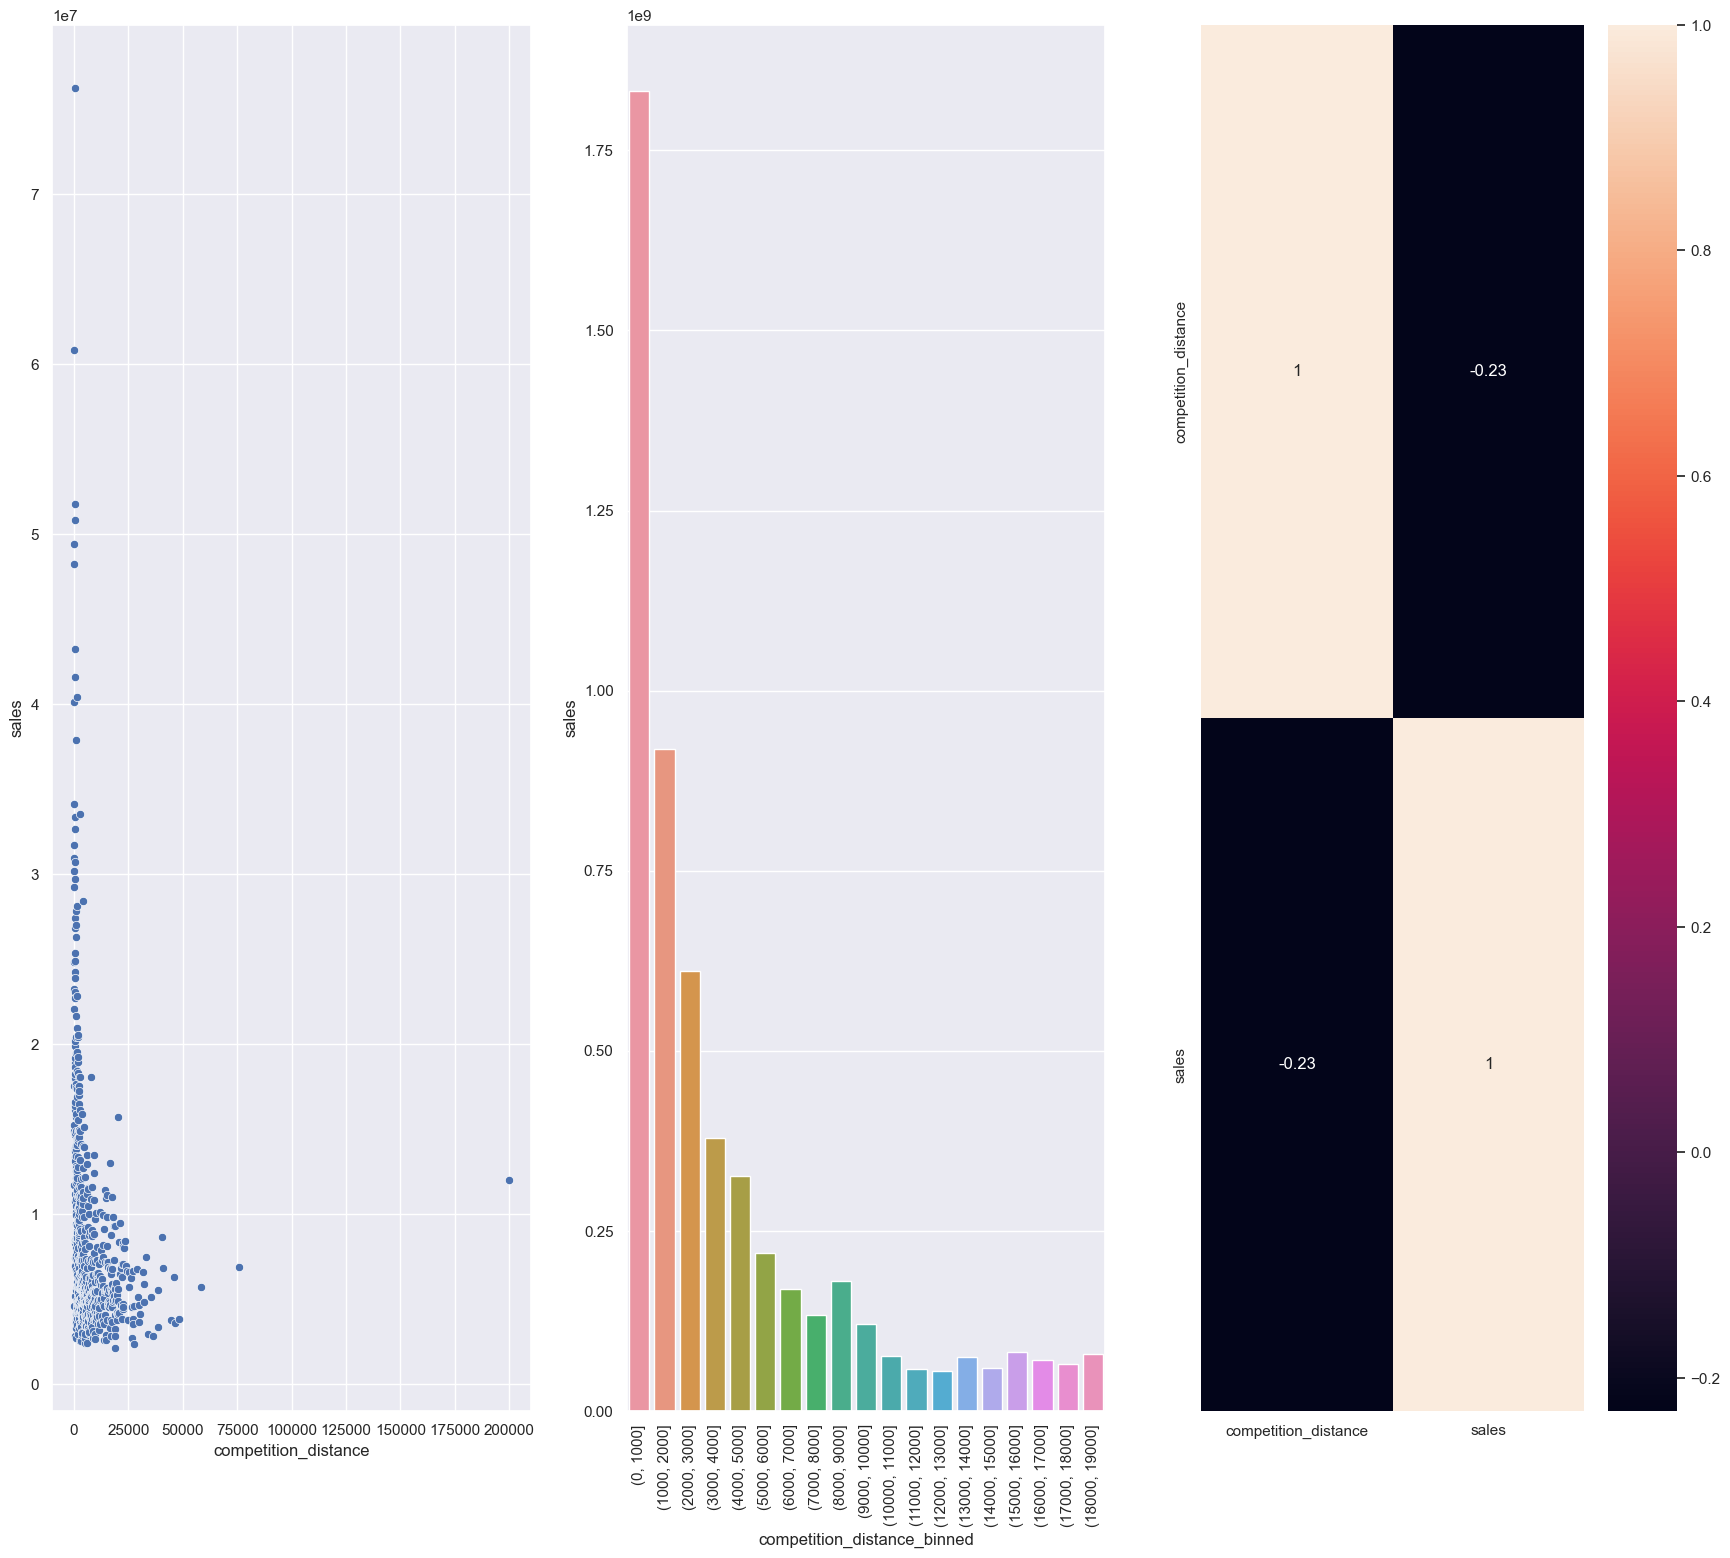

In [28]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()


plt.figure(figsize=(21,18))
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

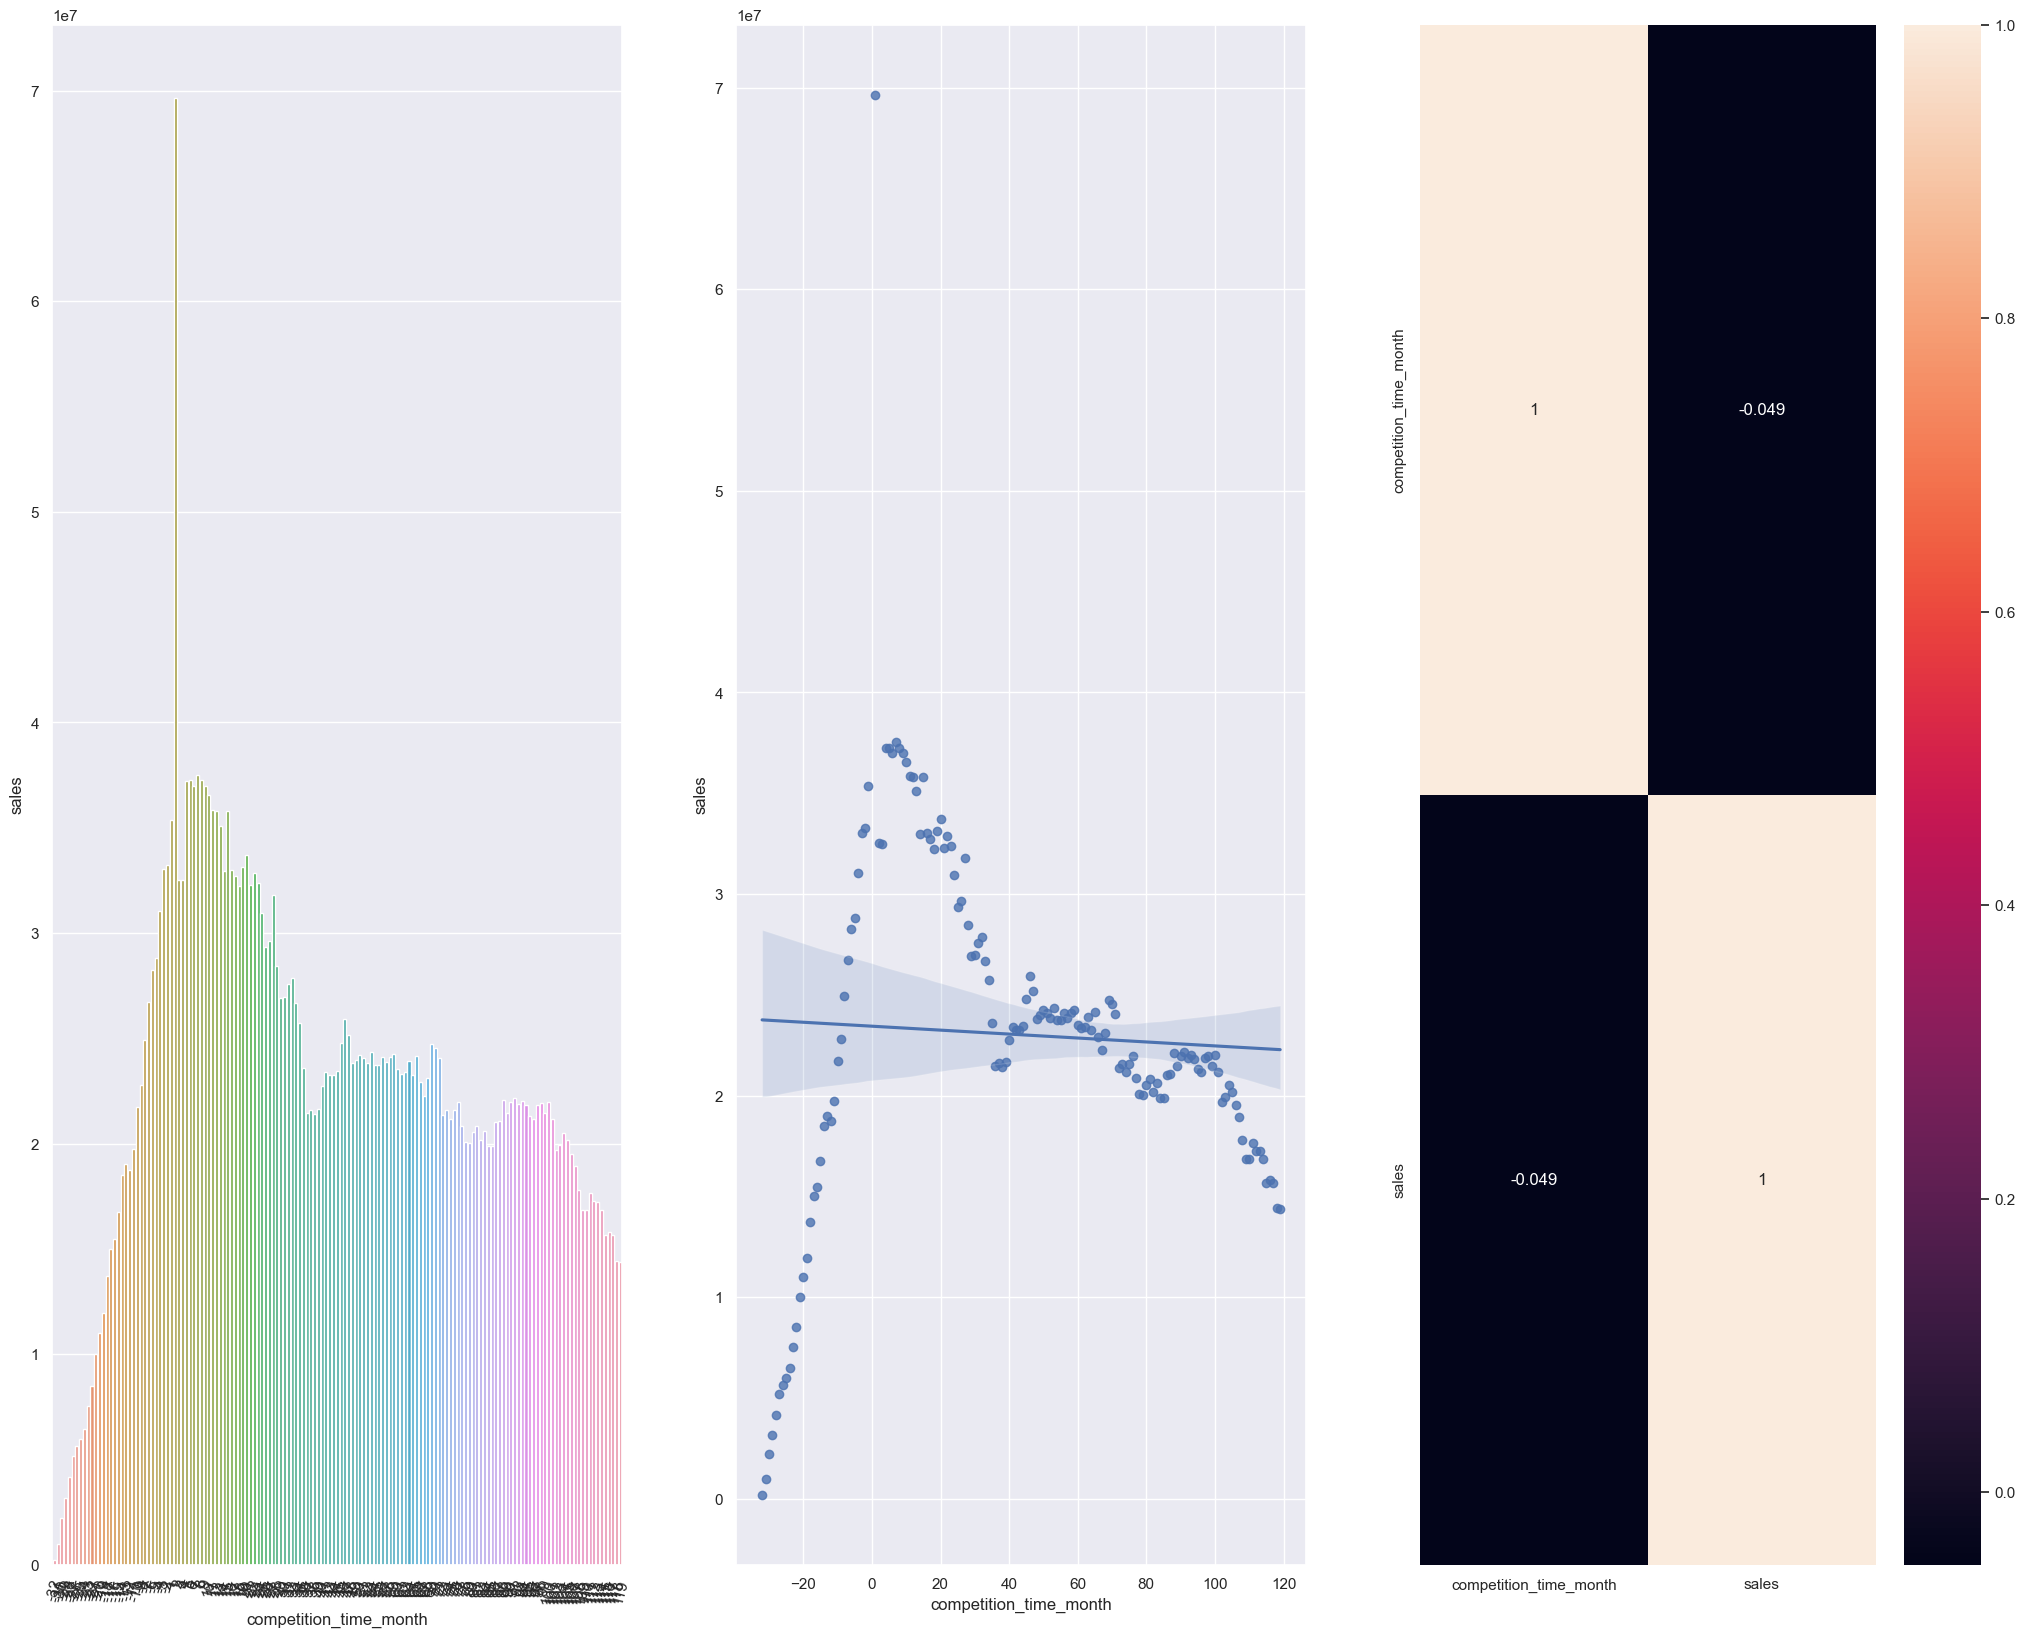

In [29]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.figure(figsize=(25,20))

plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=75);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo tempo de promoção.

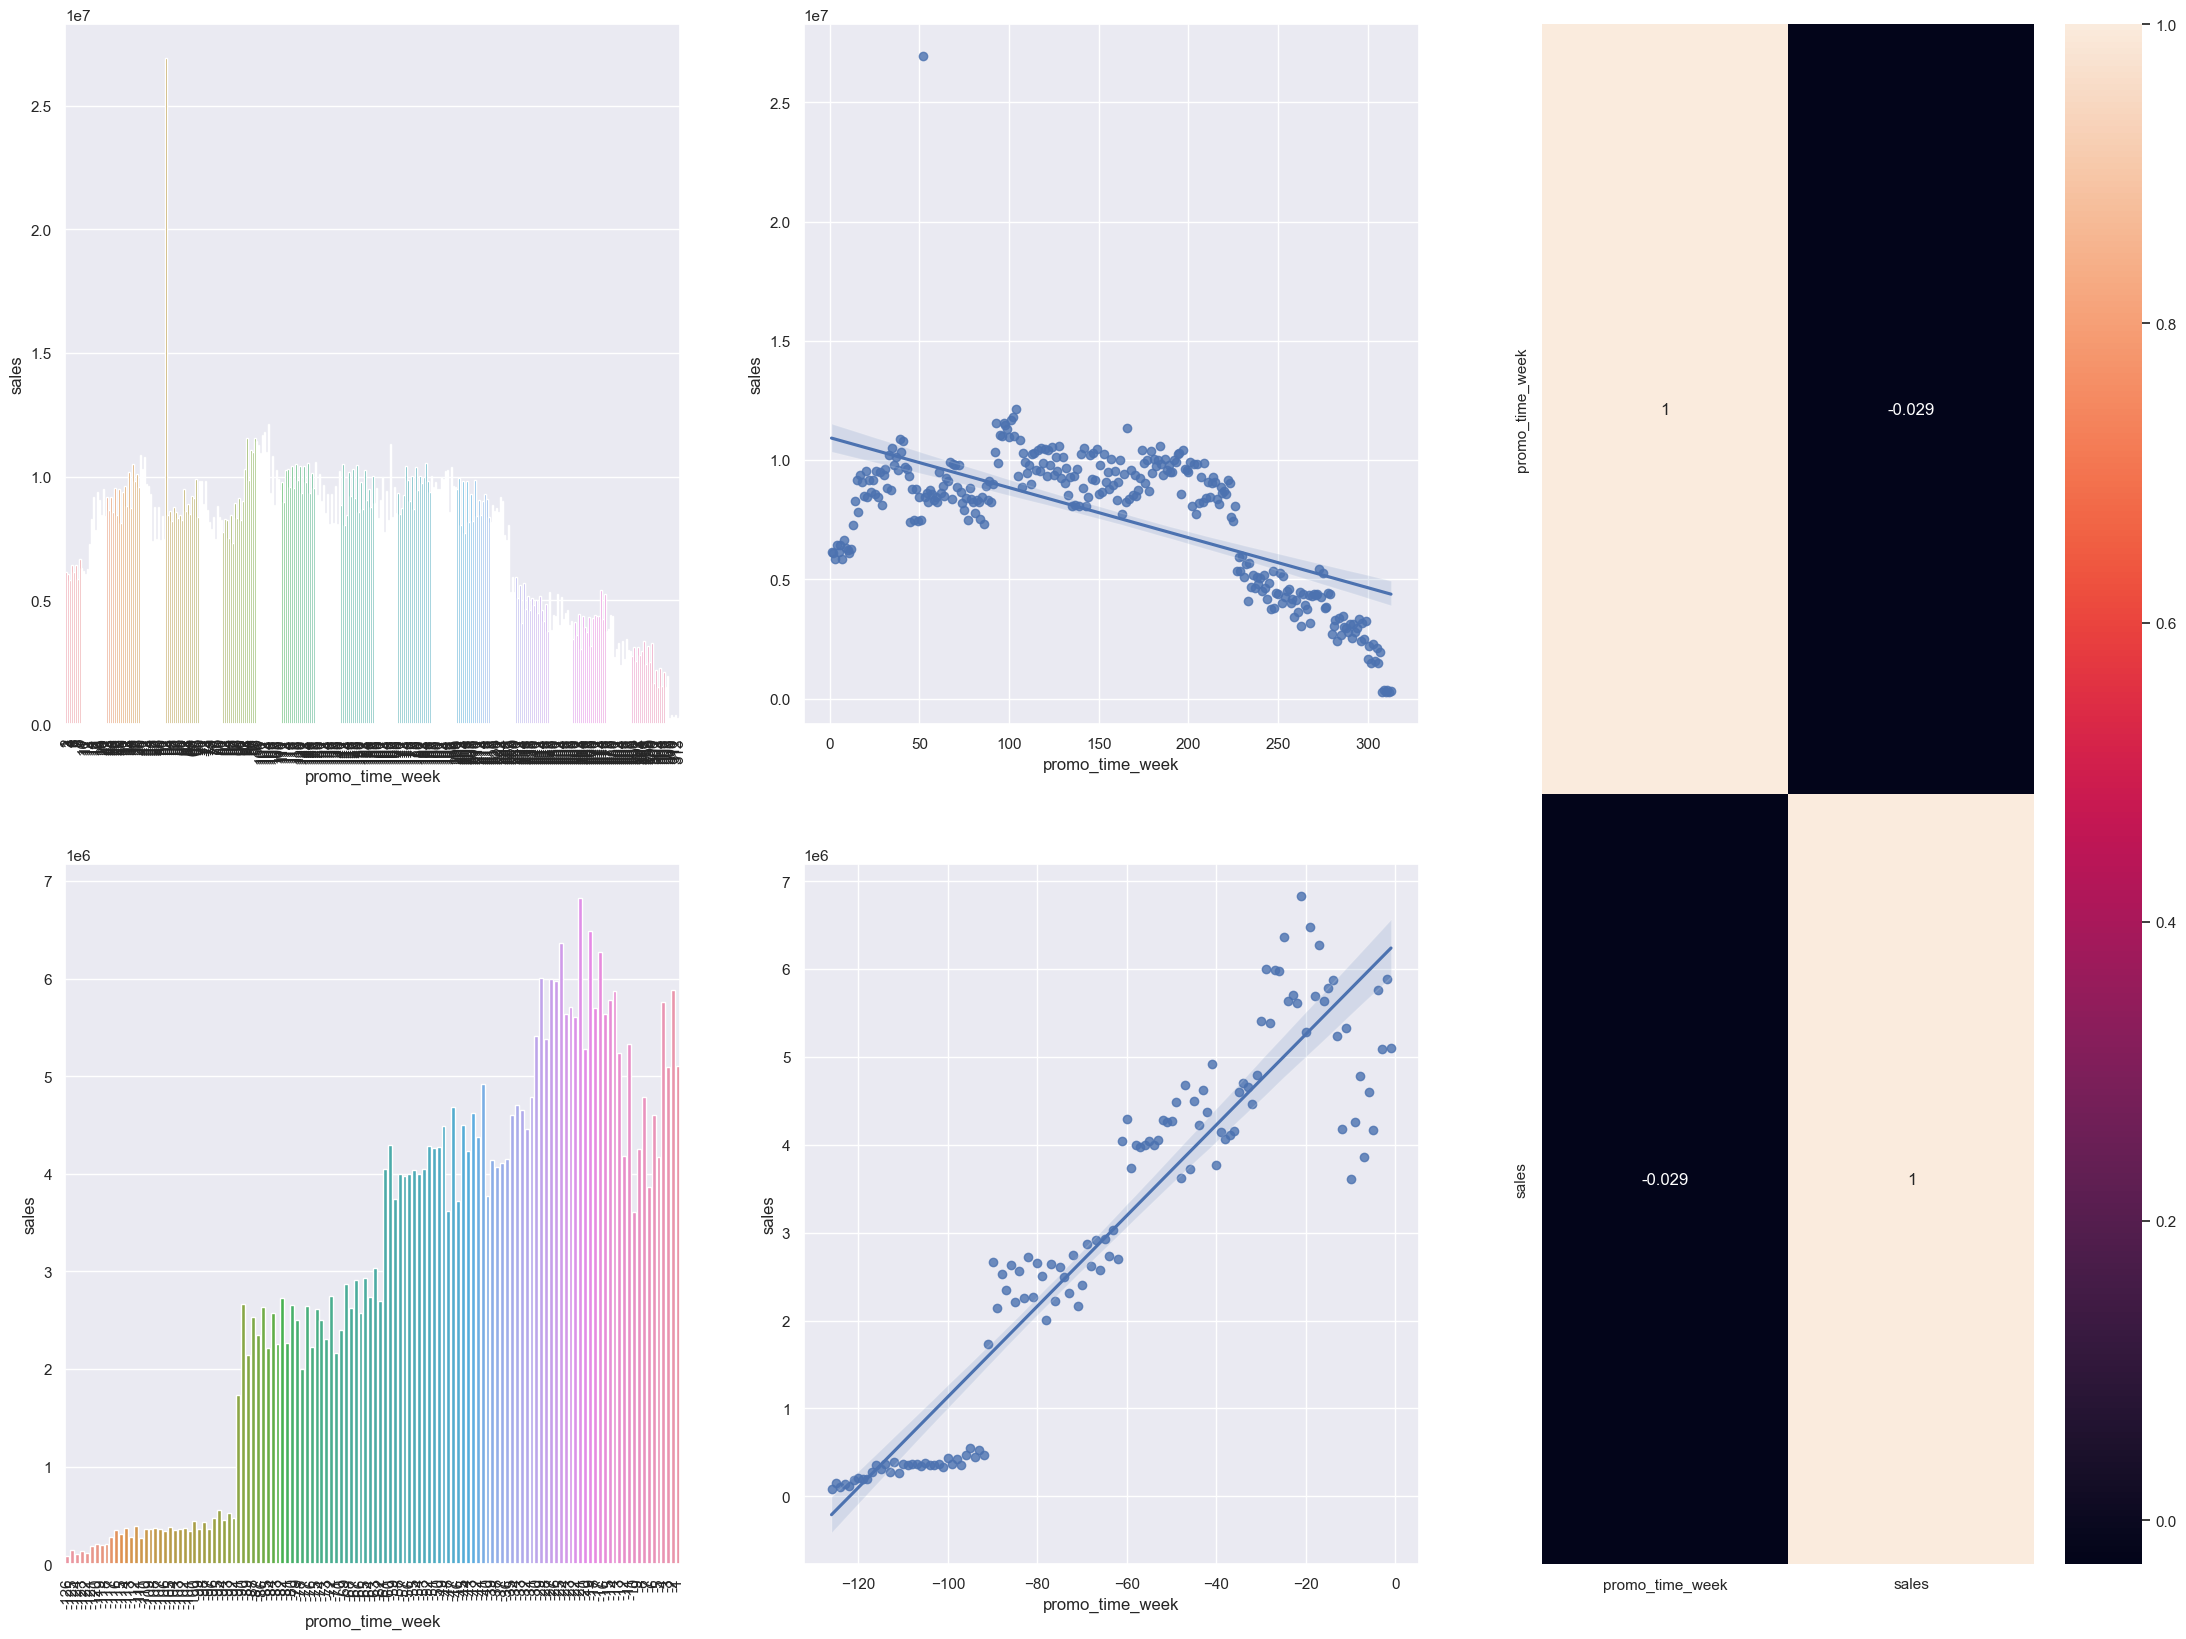

In [30]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#plt.figure(figsize=(20,12))
#sns.barplot(x='promo_time_week', y='sales', data=aux1);

grid = gs.GridSpec(2, 3)

plt.figure(figsize=(27,20))

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);


plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H5.** Lojas com mais dias de promoção deveriam vender mais.

### **H6.** Lojas com mais dias de promoções consecutivas deveriam vender mais.
**Falsa** Lojas com mais dias de promoções consecutivas vende menos.

<Figure size 2700x2000 with 0 Axes>

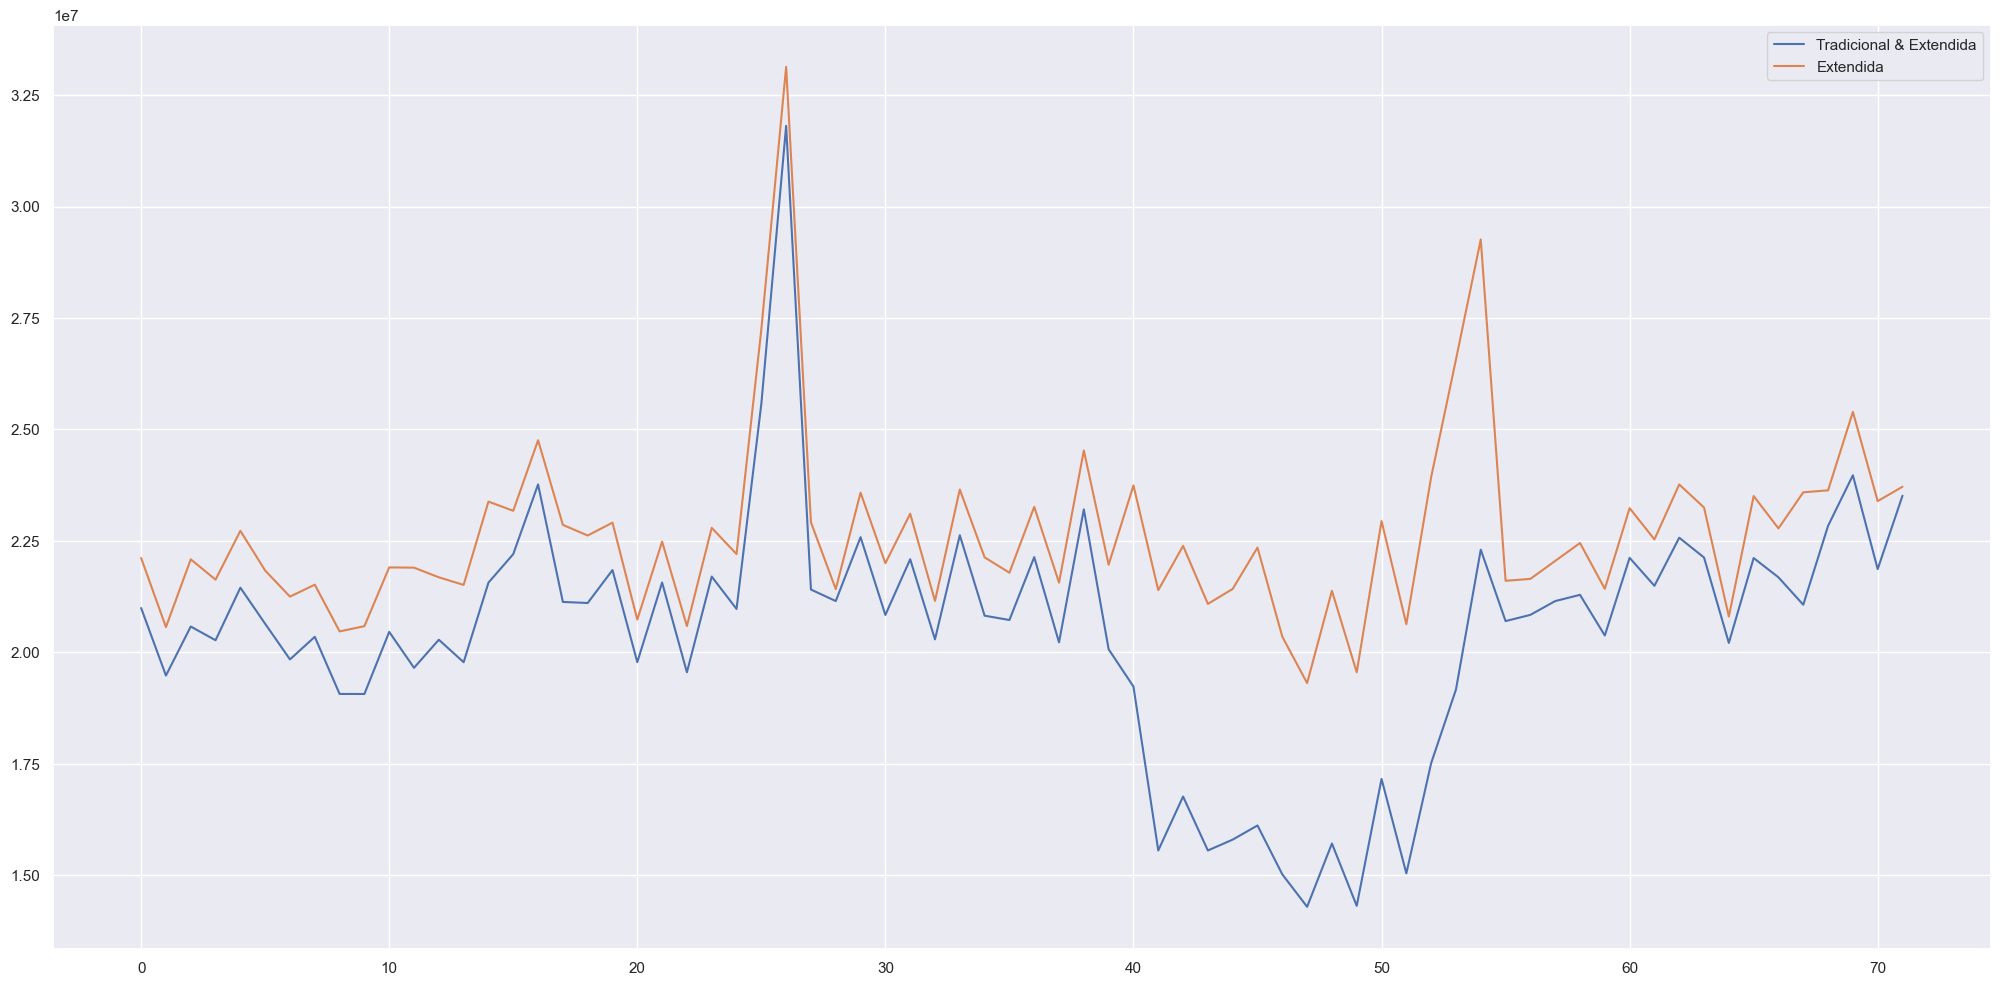

In [31]:
plt.figure(figsize=(27,20))
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa** Lojas abertas durante o feriado de natal vendem menos.

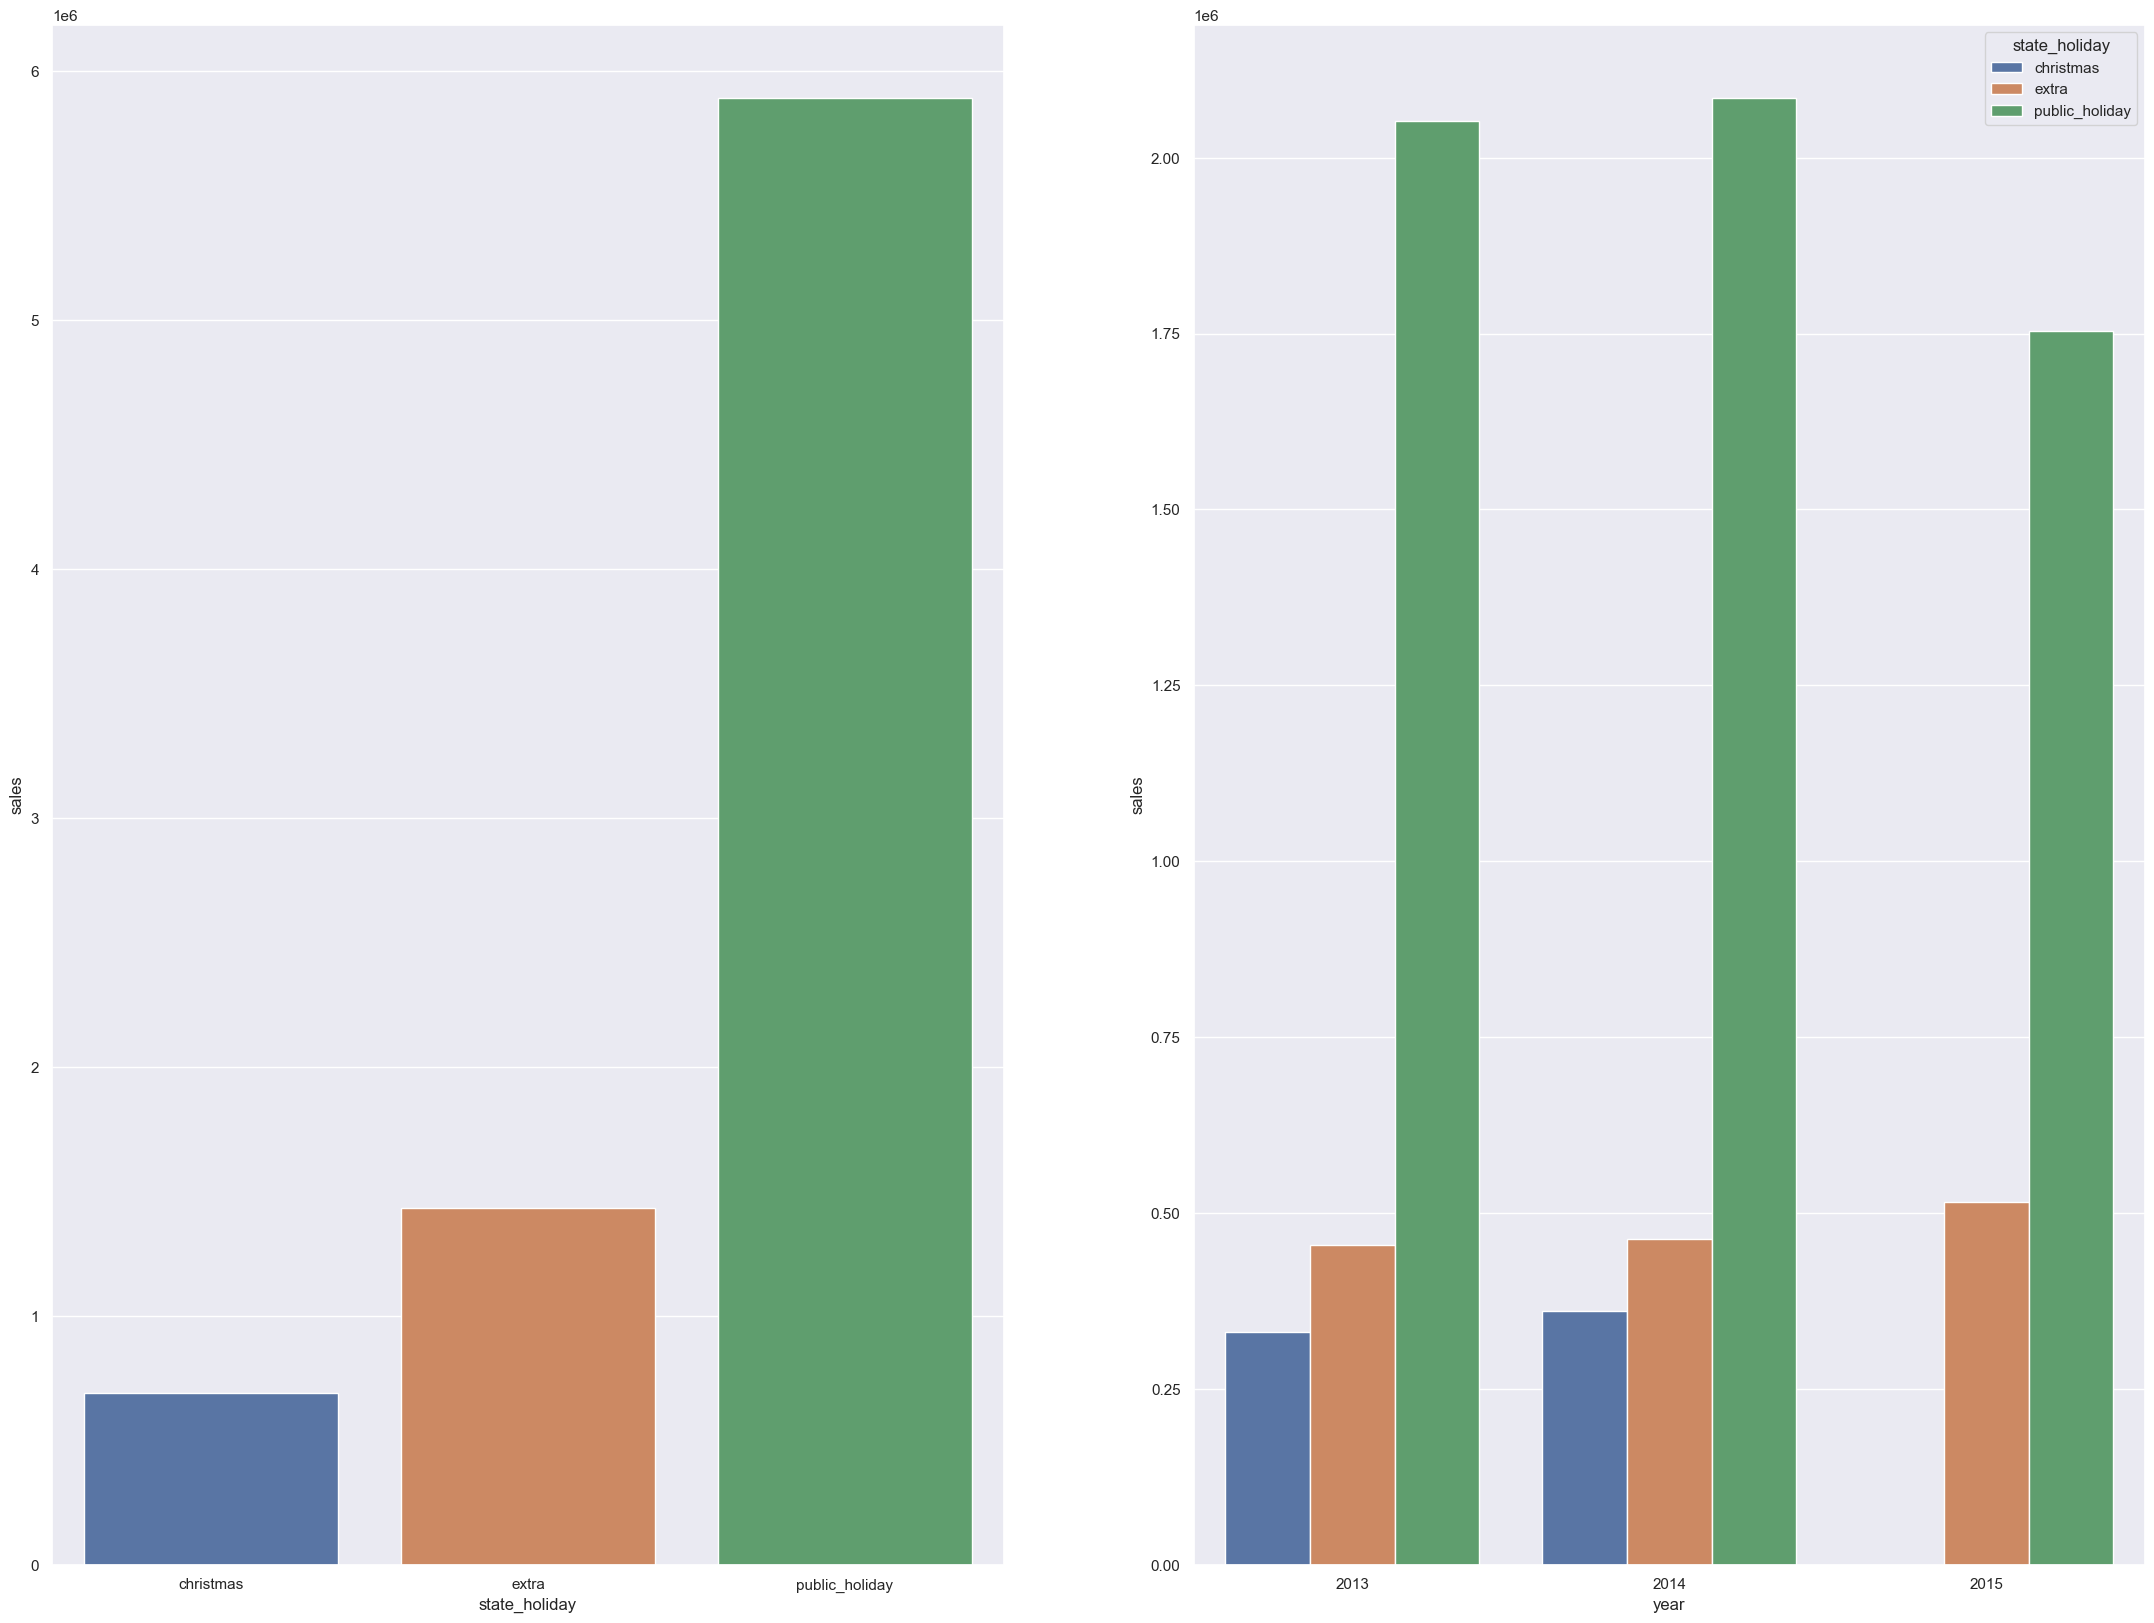

In [32]:
aux = df4[ df4['state_holiday'] != 'regular_day']

plt.figure(figsize=(27,20))
plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos.

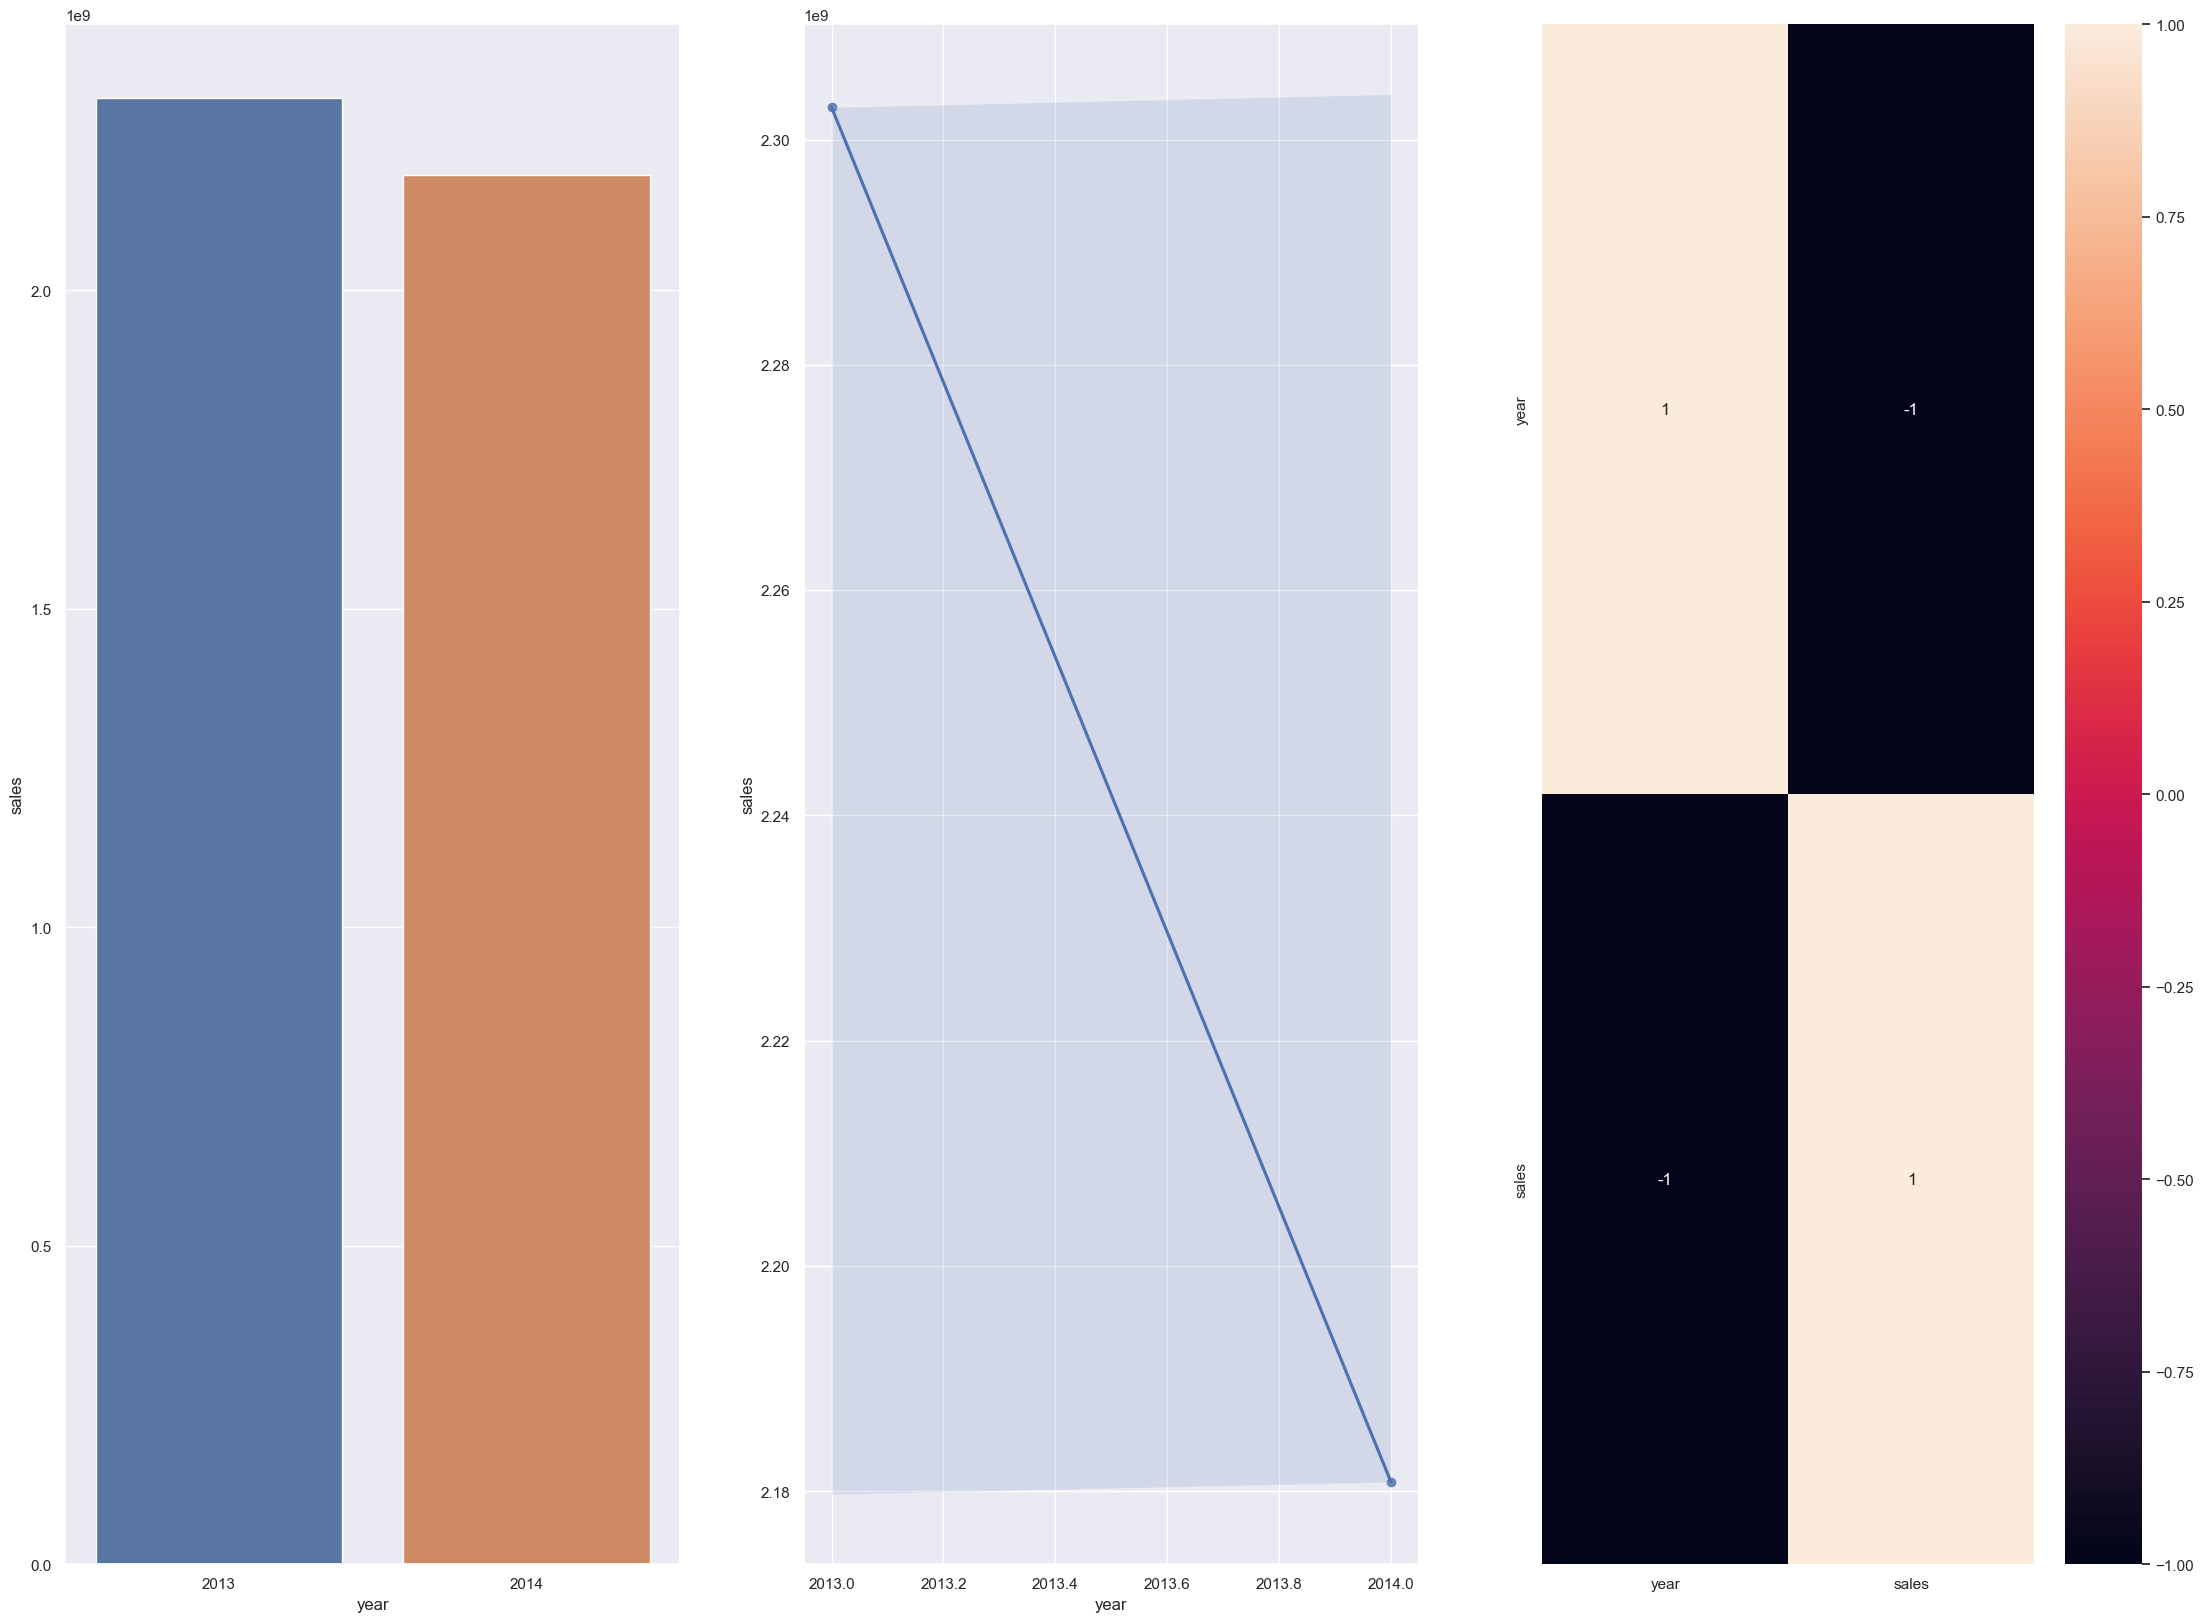

In [33]:
aux = df4[df4['year'] < 2015]

plt.figure(figsize=(27,20))
plt.subplot(1,3,1)
aux1 = aux[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### **H9.** Lojas deveriam vender mais no segundo semetre do ano.
**Falsa** Lojas vendem menos no segundo semestre do ano.

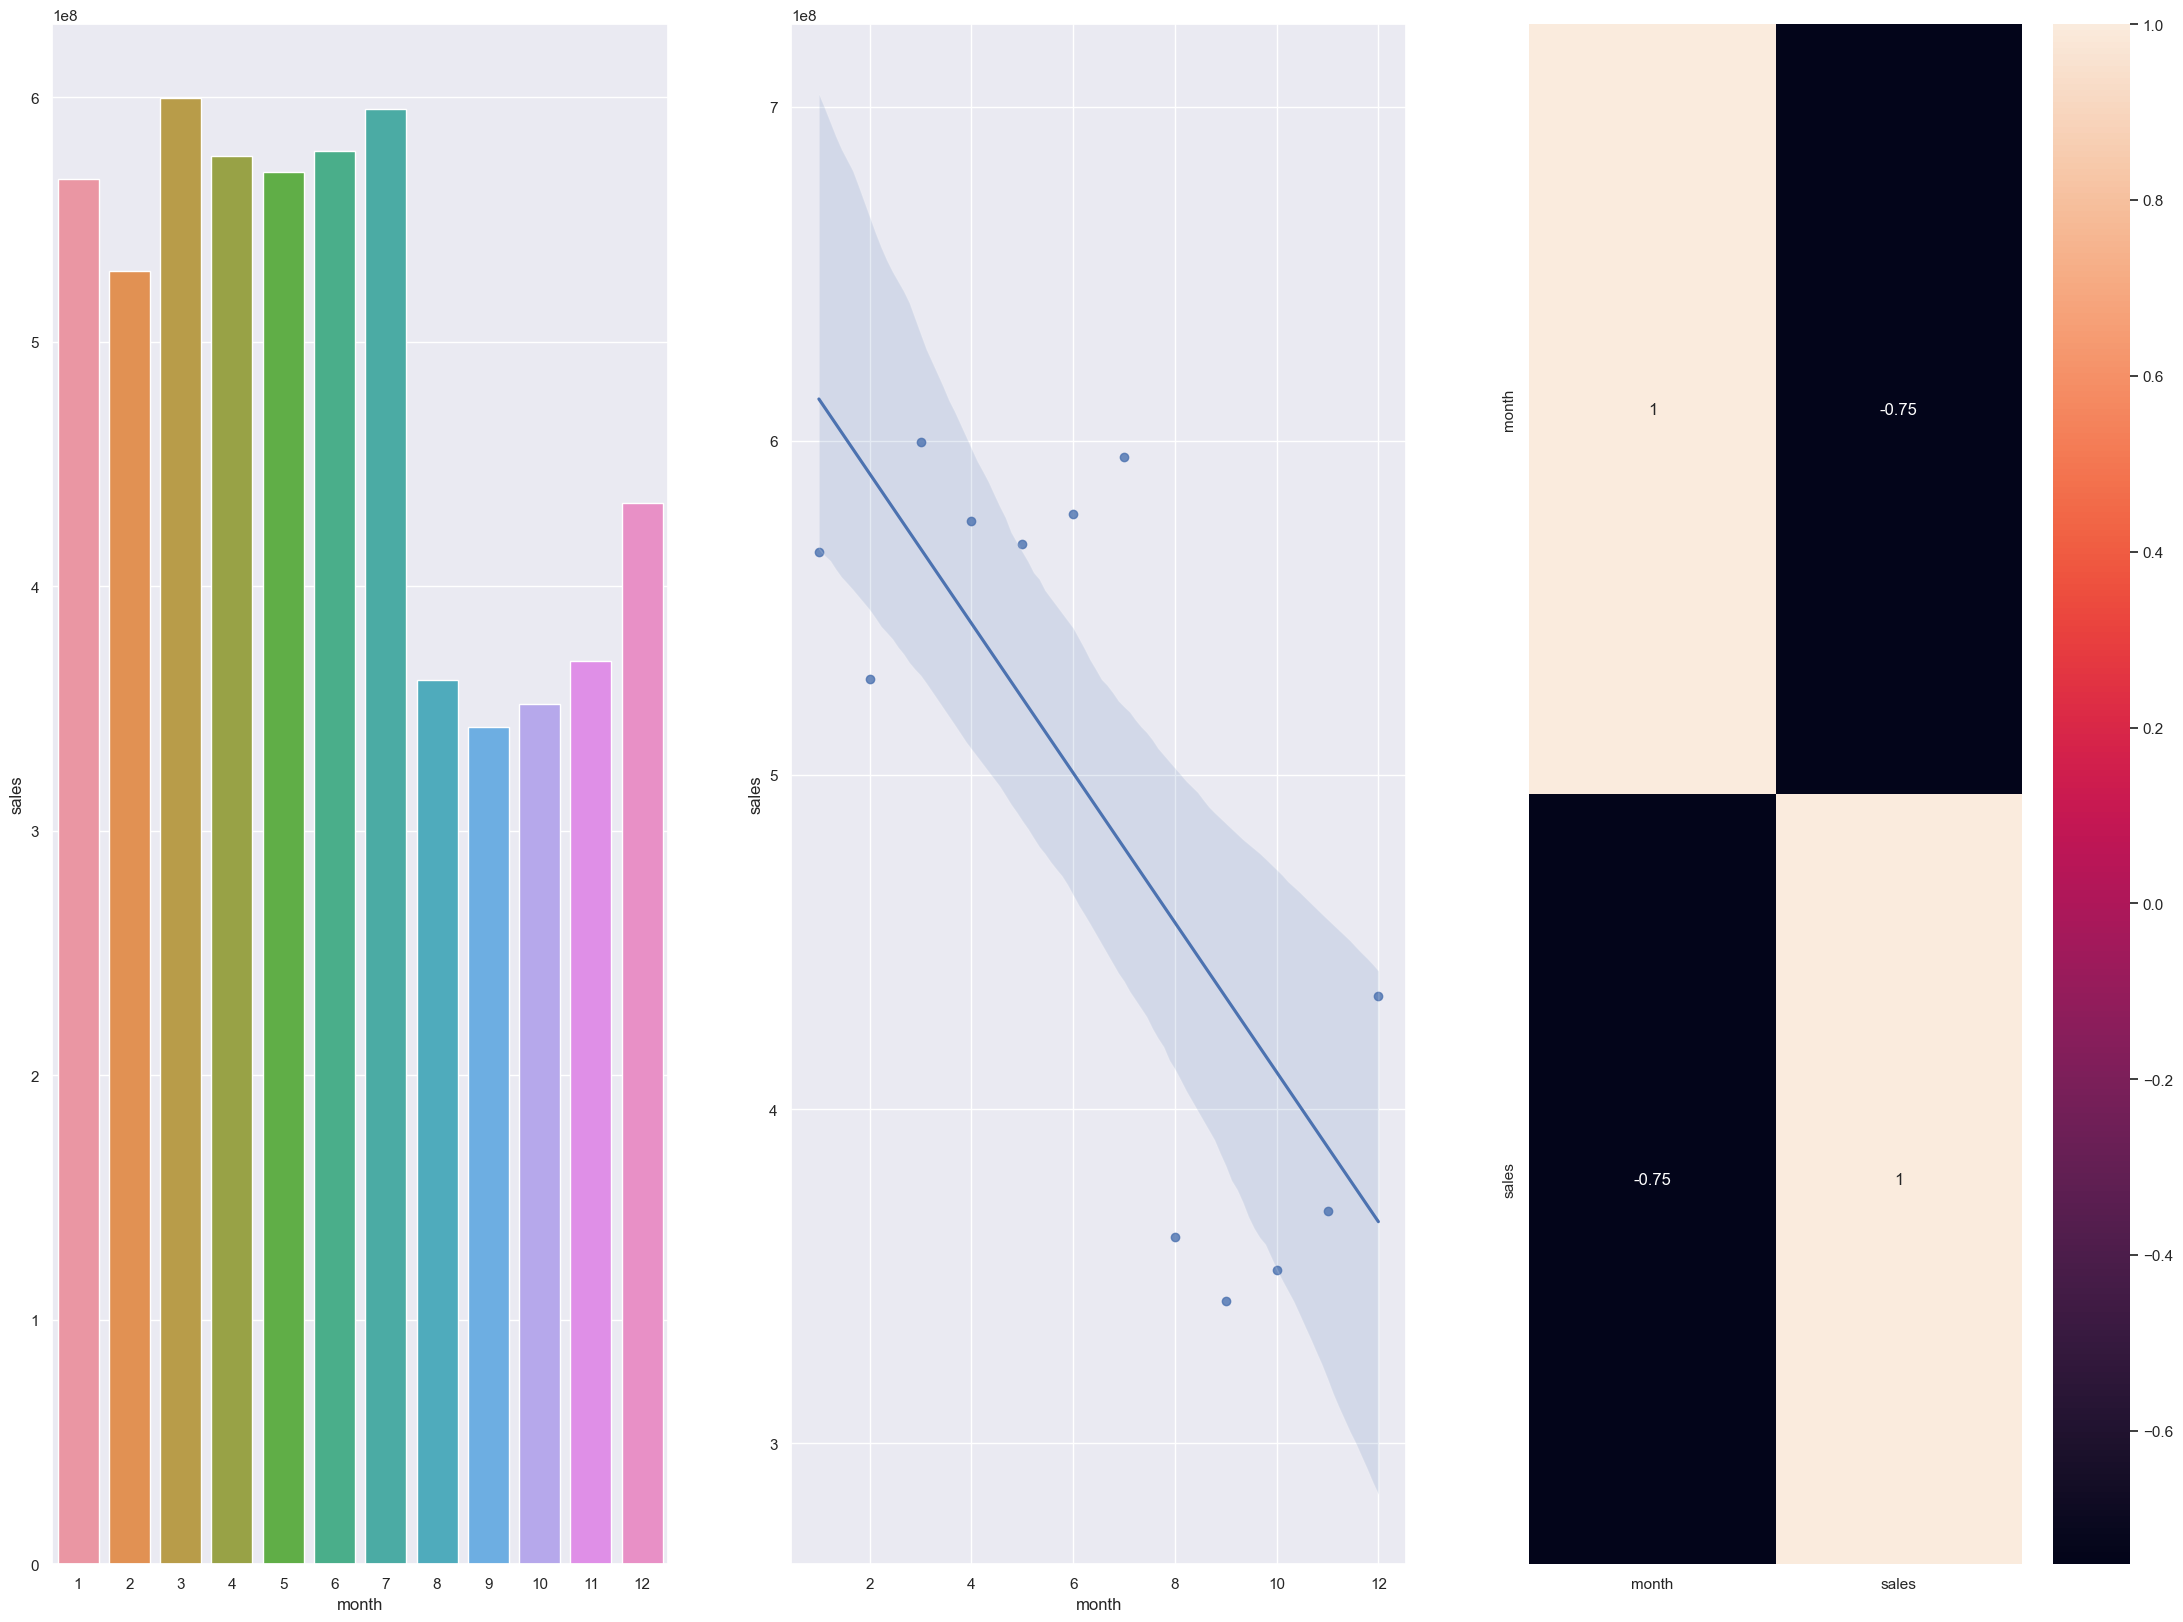

In [34]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(27,20))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

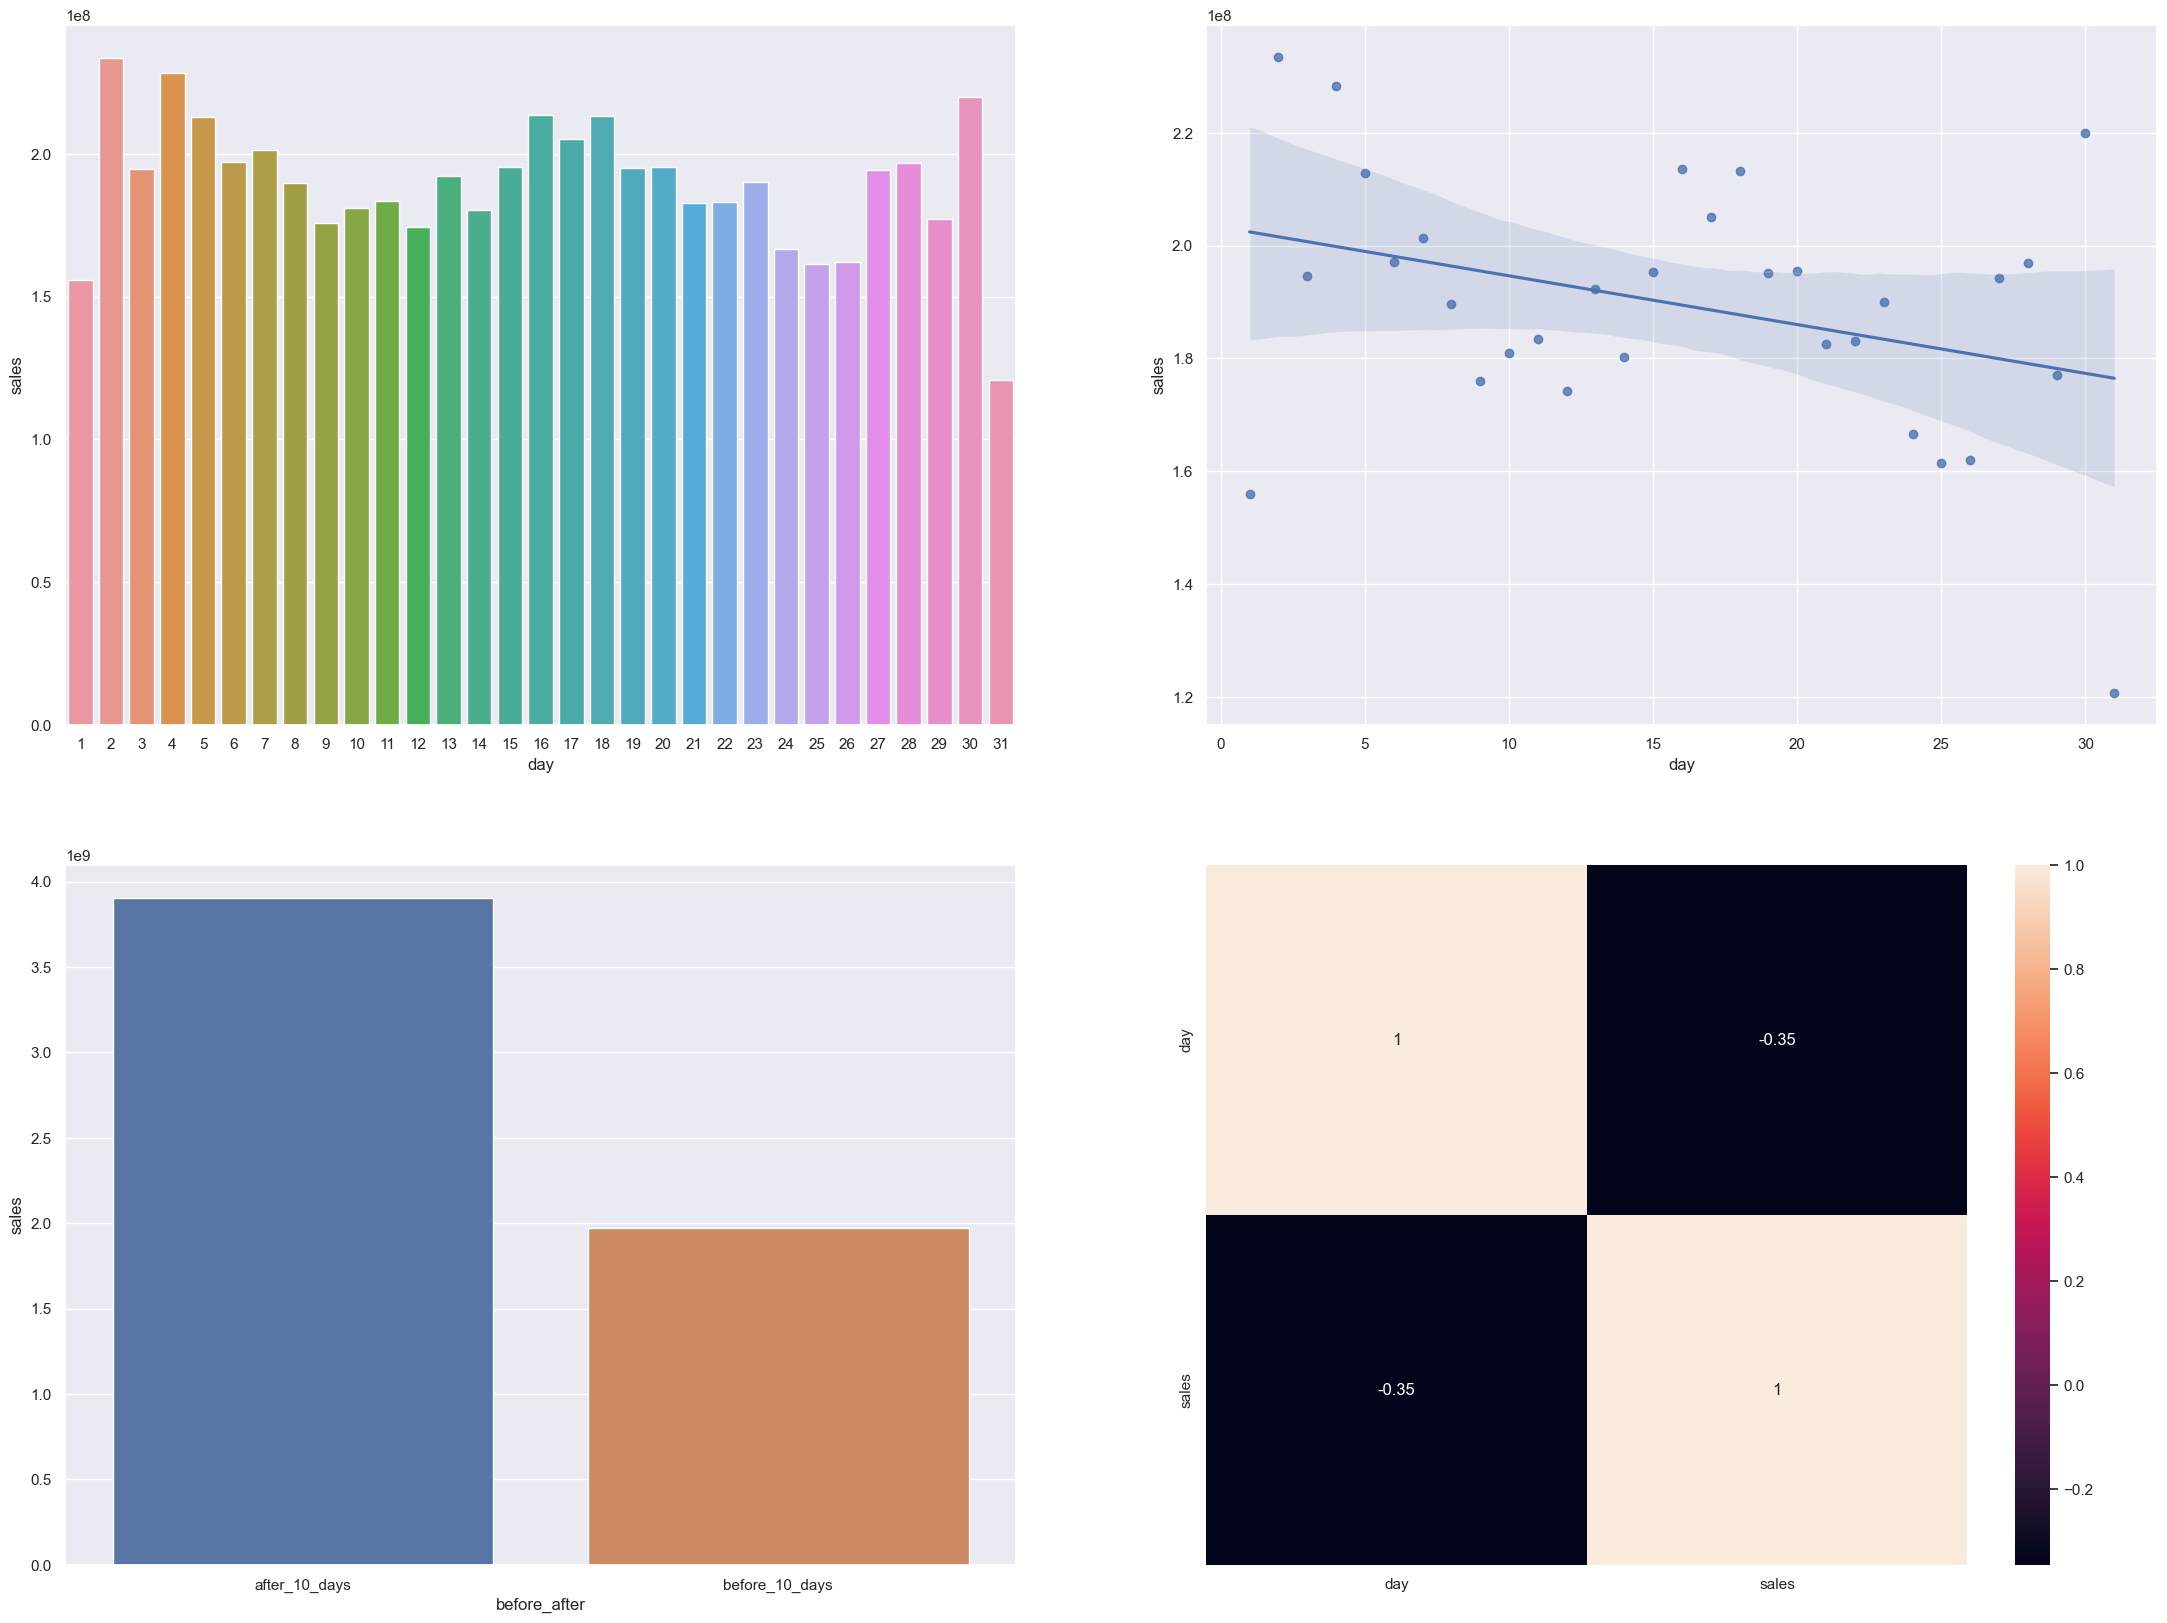

In [35]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(27,20))
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 3)
sns.barplot(x='before_after', y='sales', data=aux2);

plt.subplot(2, 2, 4)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H11.** Lojas deveriam vender menos aos finais de semana.
**Verdadeiro** Lojas vendem menos aos finais de semana.

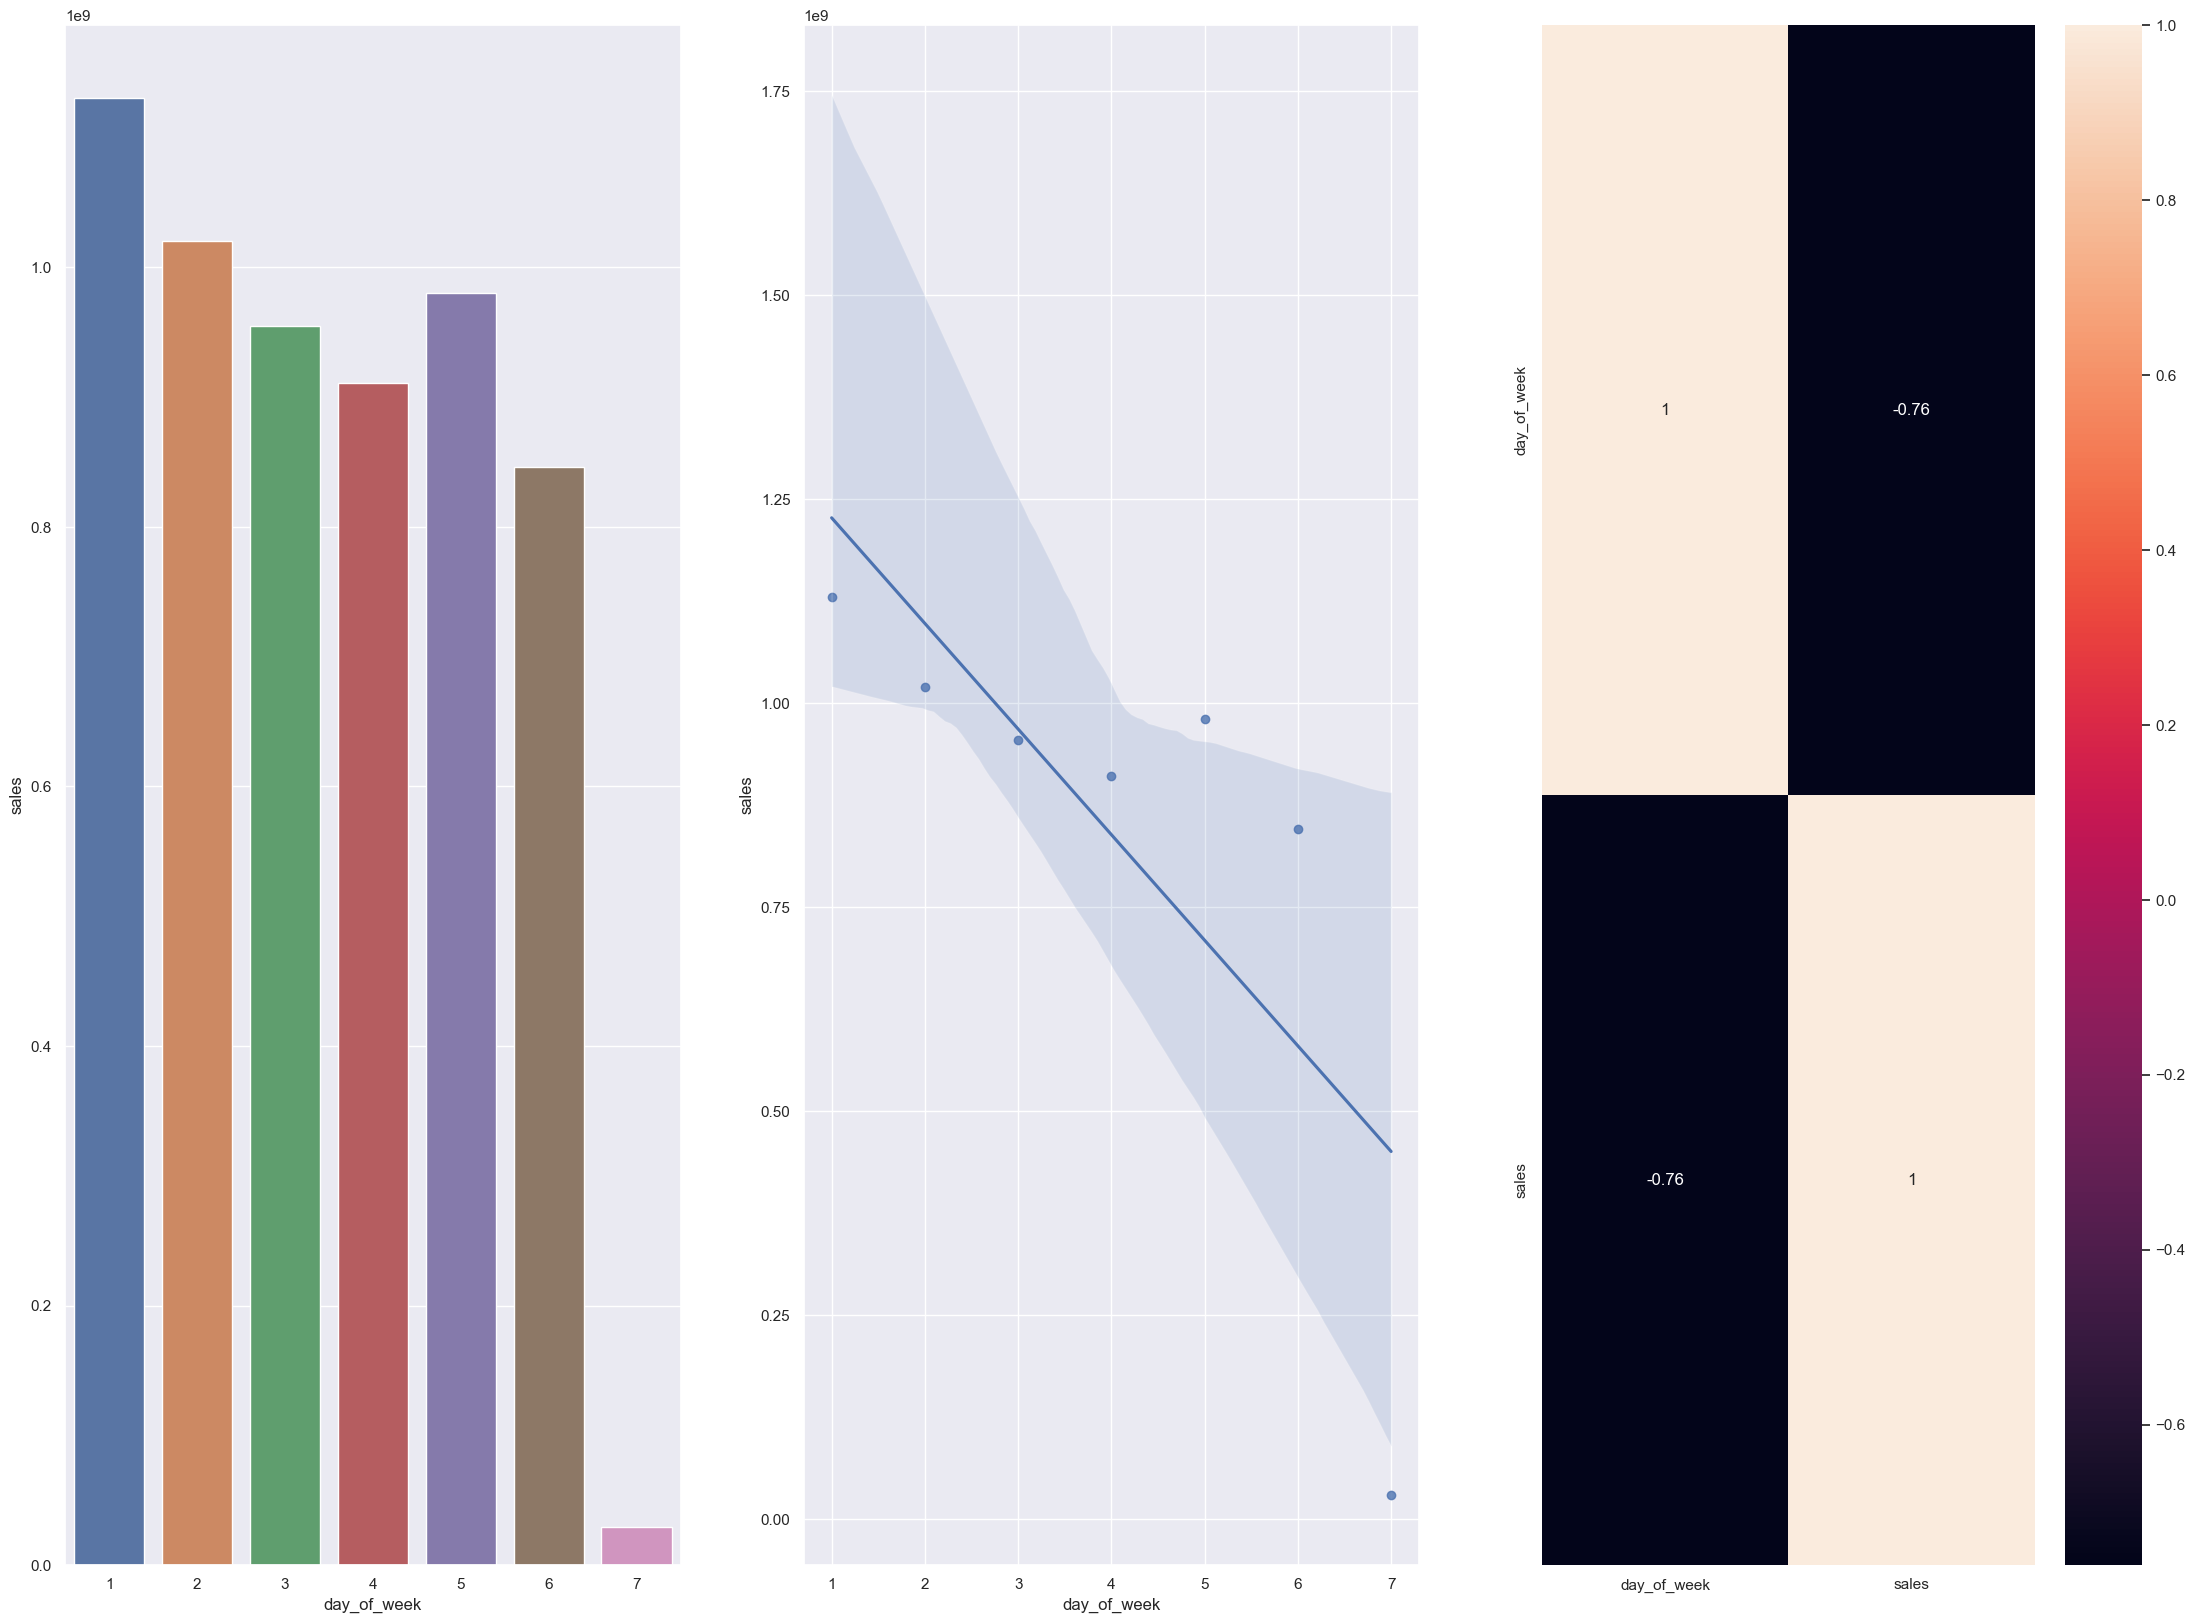

In [36]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize = (27,20))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

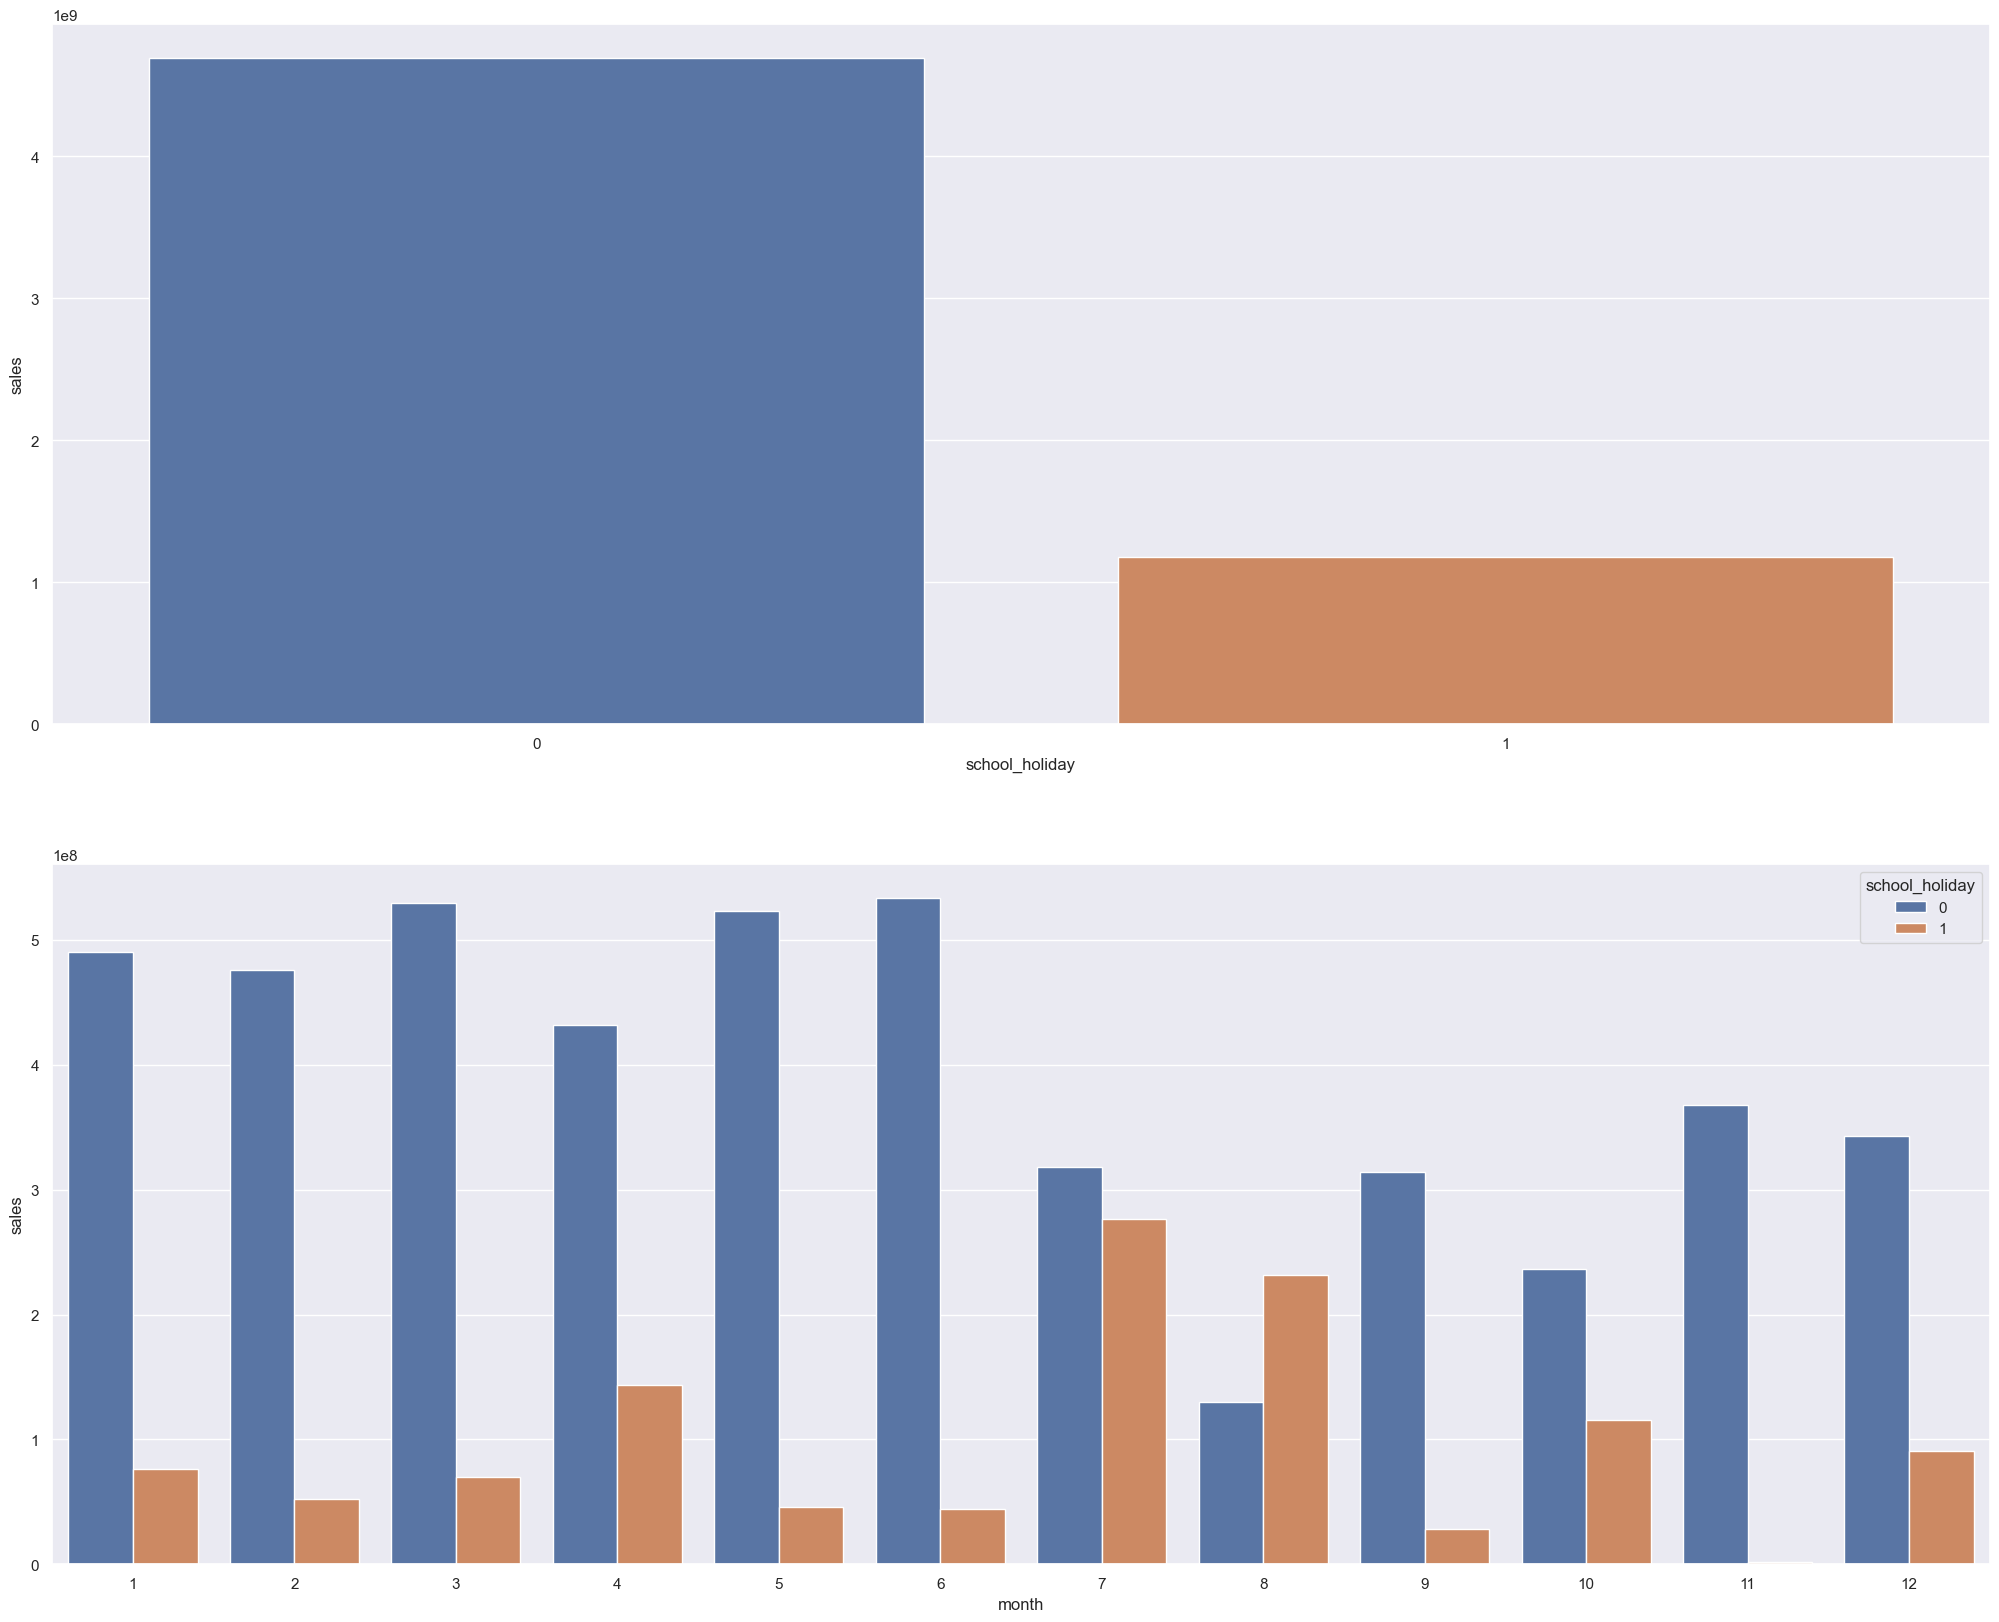

In [37]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.figure(figsize=(25,20))
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Resumo das Hipóteses

In [38]:
tab = [['Hipótese', 'Conclusão', 'Relevancia'], 
       ['H1', 'Falsa', 'Baixa'], 
       ['H2', 'Falsa', 'Media'], 
       ['H3', 'Falsa', 'Media'], 
       ['H4', 'Falsa', 'Baixa'], 
       ['H5', '-', '-'], 
       ['H6', 'Falsa', 'Baixa'], 
       ['H7', 'Falsa', 'Media'], 
       ['H8', 'Falsa', 'Alta'], 
       ['H9', 'Falsa', 'Alta'], 
       ['H10', 'Verdadeira', 'Alta'], 
       ['H11', 'Verdadeira', 'Alta'], 
       ['H12', 'Verdadeira', 'Baixa']]

print(tabulate(tab, headers='firstrow'))

Hipótese    Conclusão    Relevancia
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Media
H3          Falsa        Media
H4          Falsa        Baixa
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Media
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Alta
H11         Verdadeira   Alta
H12         Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes

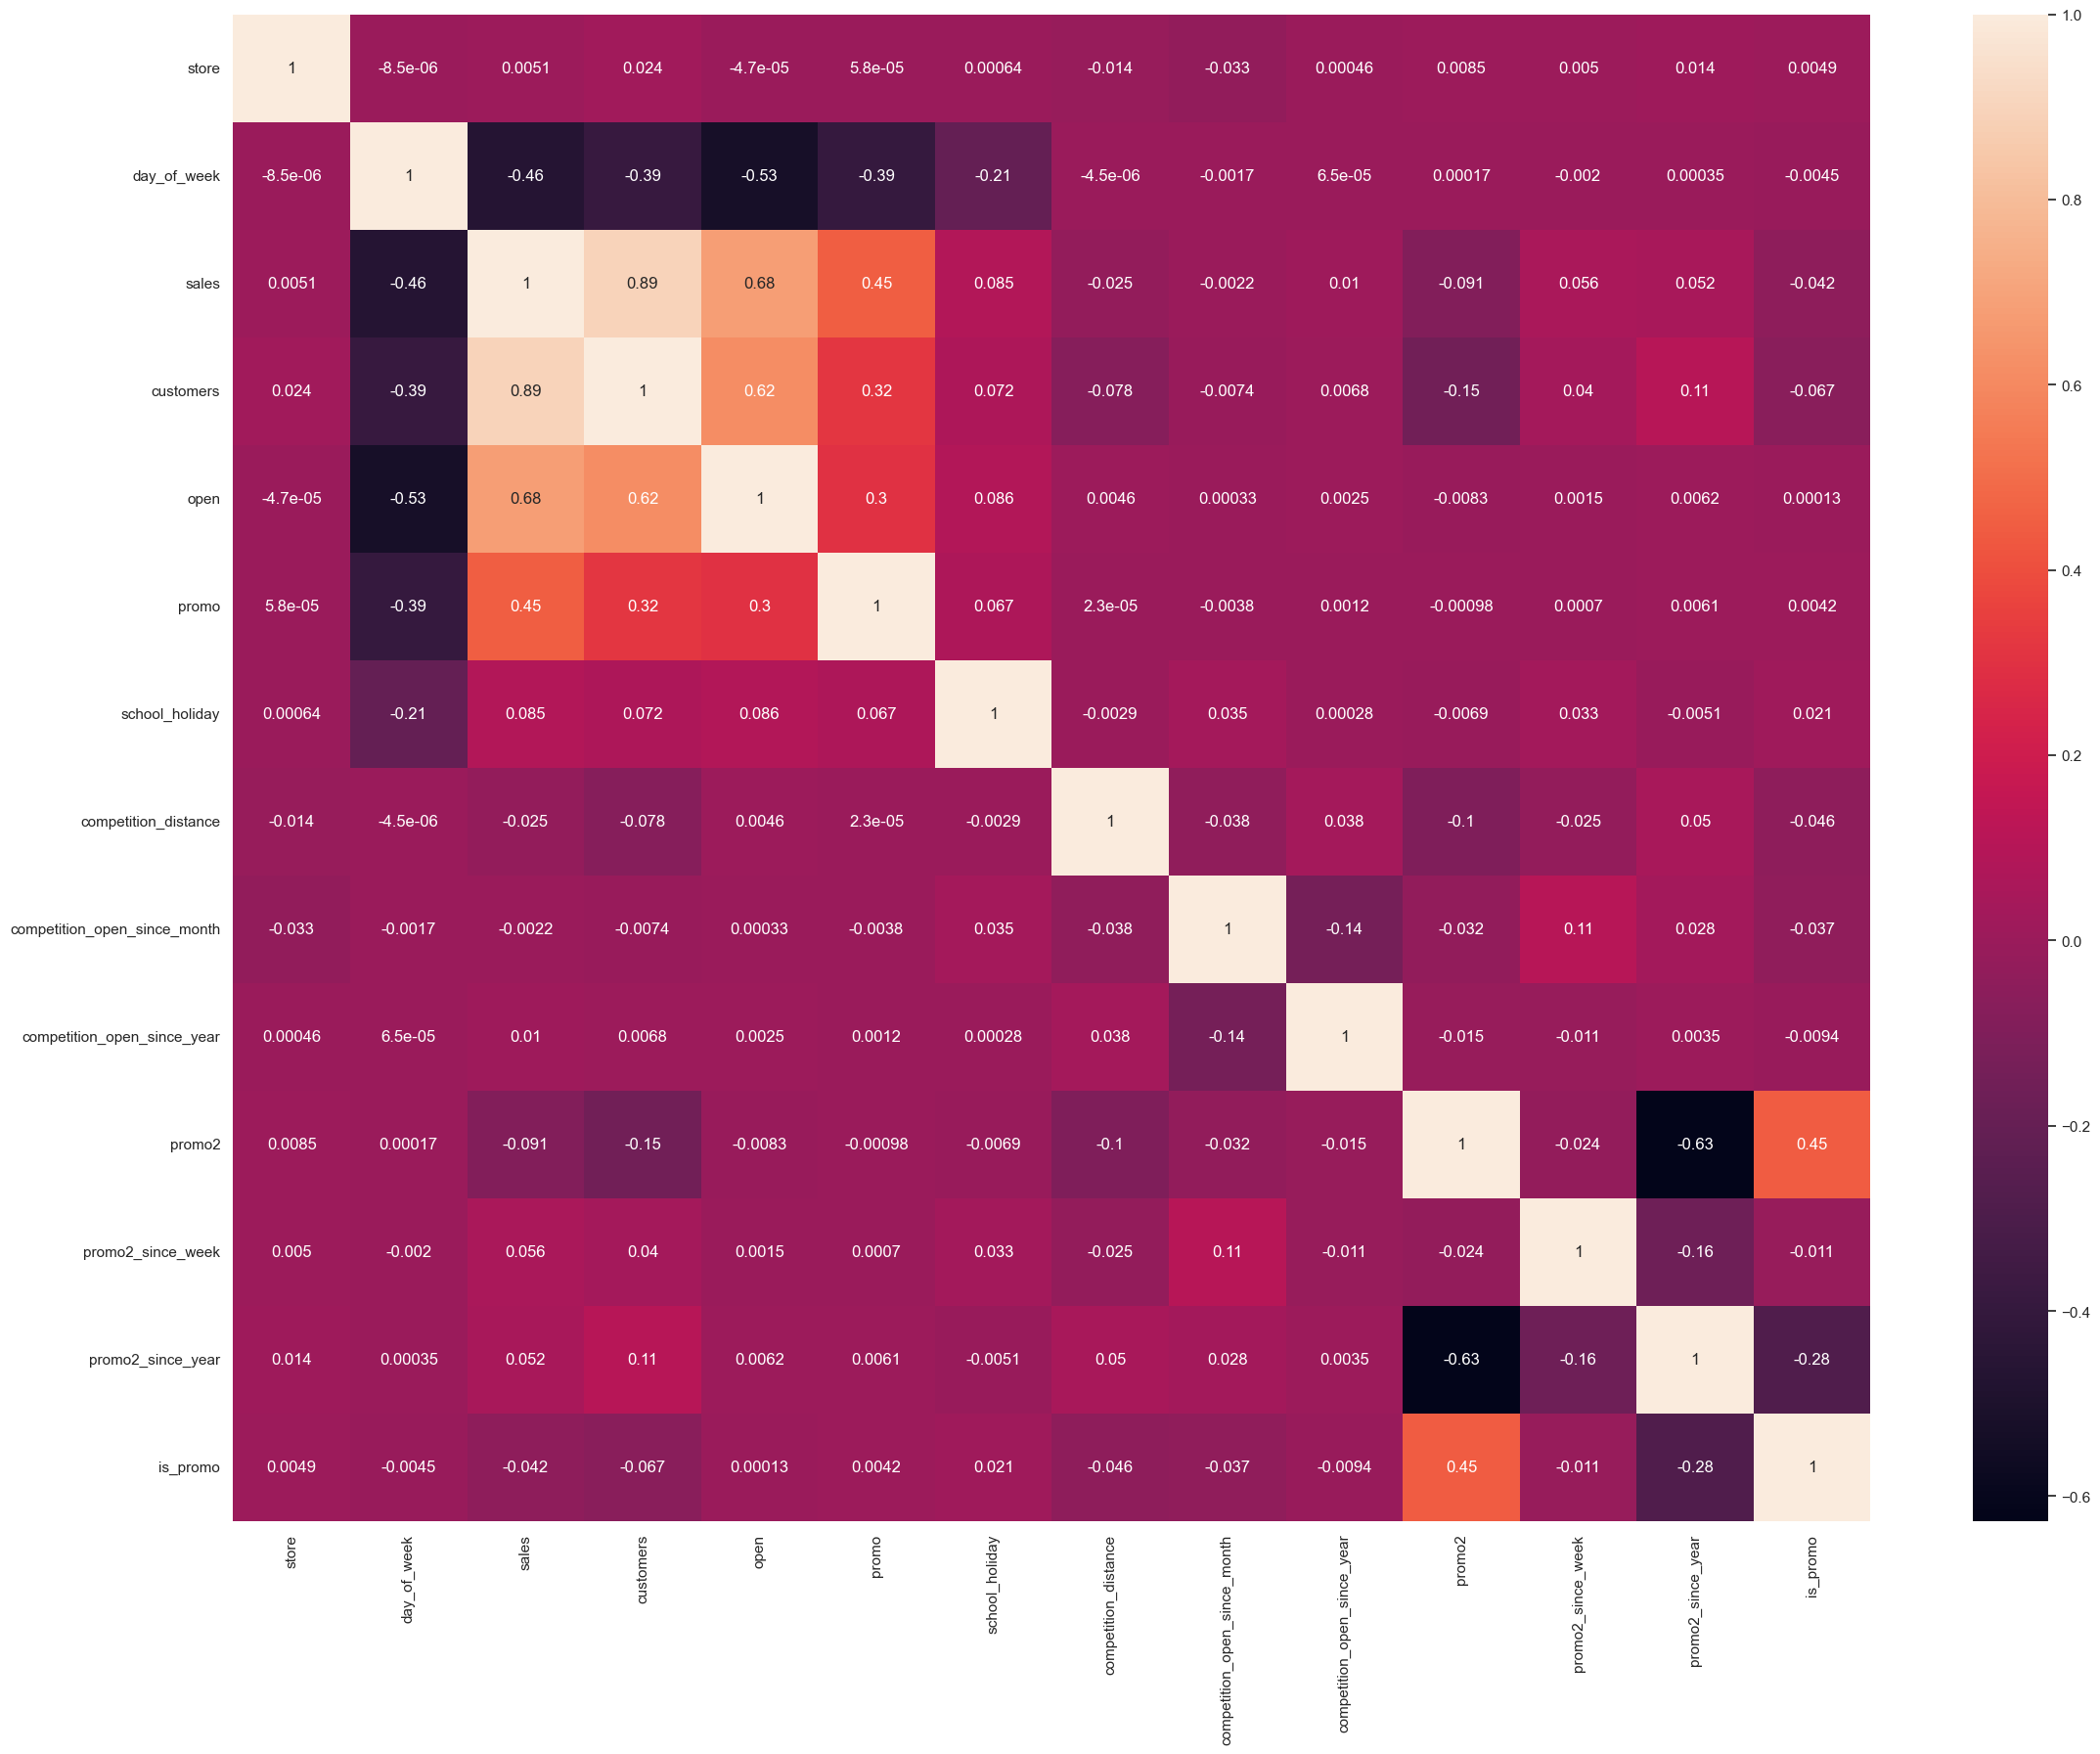

In [39]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(27,20))
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Atributtes

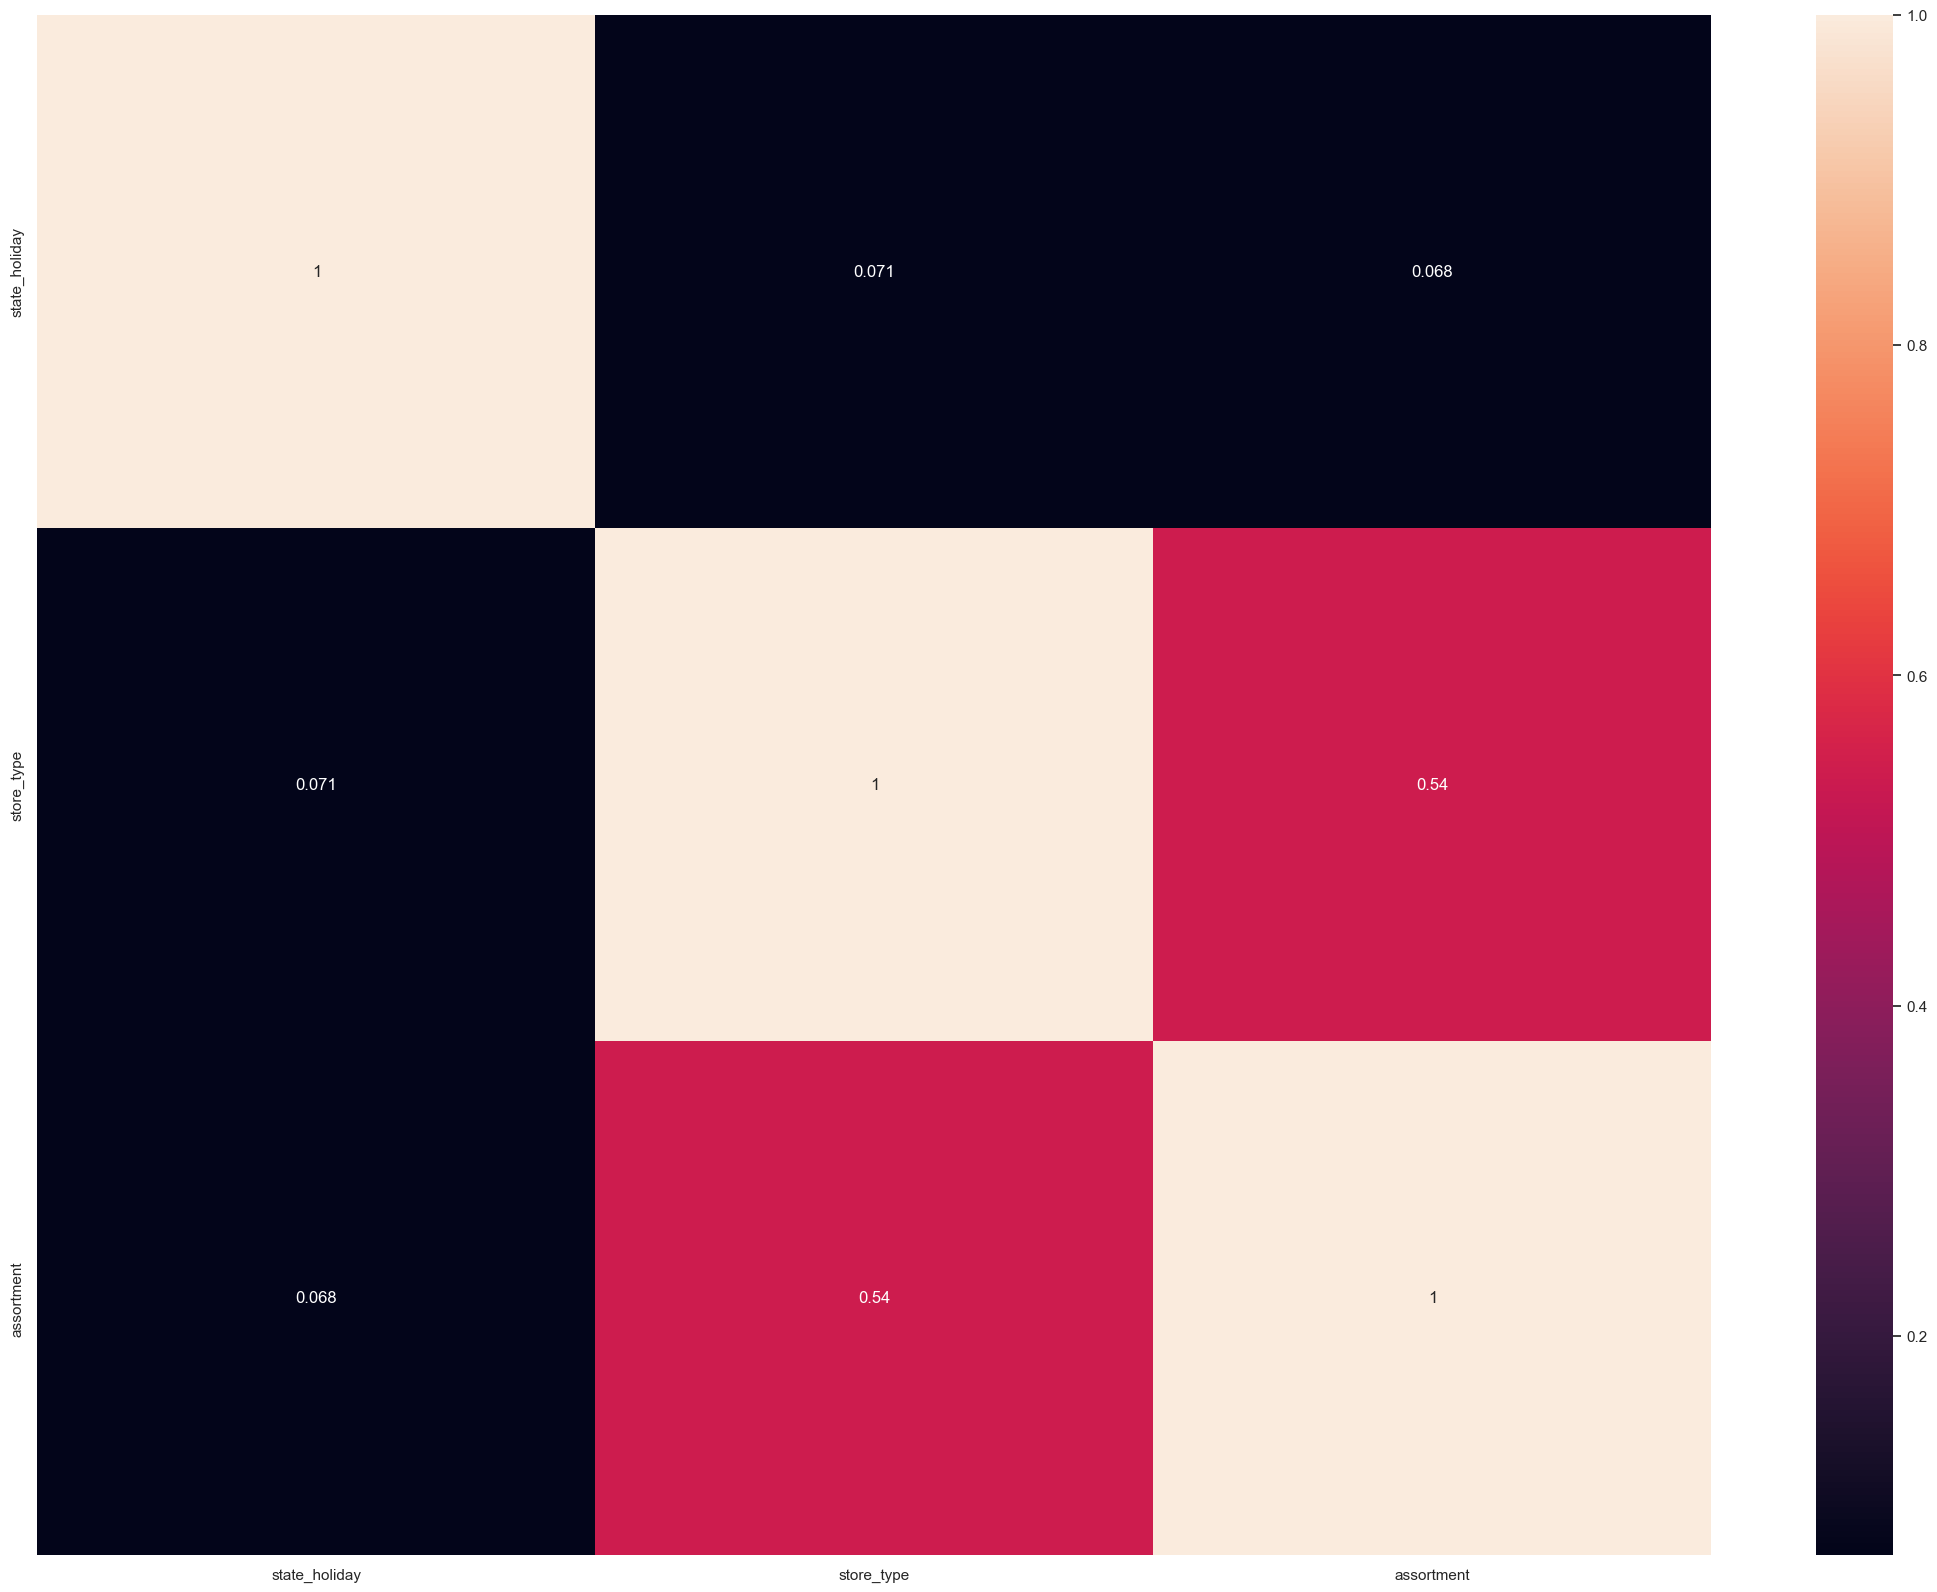

In [40]:
a = df4.select_dtypes(include='object')

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

b1 = cramer_v(a['store_type'], a['state_holiday'])
b2 = cramer_v(a['store_type'], a['store_type'])
b3 = cramer_v(a['store_type'], a['assortment'])

c1 = cramer_v(a['assortment'], a['state_holiday'])
c2 = cramer_v(a['assortment'], a['store_type'])
c3 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday':[a1, a2, a3], 
              'store_type': [b1, b2, b3], 
              'assortment': [c1, c2, c3]})

d = d.set_index(d.columns)

plt.figure(figsize = (27,20))
sns.heatmap(d, annot=True);

# 5.0 Passo 05 - Preparação dos Dados

In [41]:
df5 = df4.copy()

## 5.1. Normalização

Ao analisar as variáveis numéricas na seção Numerical atributtes da análise univariada, vimos que nenhum variável tem um comportamento normal. Dessa maneira, não vamos aplicar em nenhuma delas a normalização para evitar forçar tal questão. Assim, vamos usar o Rescaling para resolver essa parte.

## 5.2 Rescaling

In [42]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## 5.6. Transformação

### 5.6.1. Encoding

In [43]:
le = LabelEncoder()

# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix='state_holiday', columns=['state_holiday'])

# store_type - Label Encoding
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}

df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.6.2. Responde Variable Transformation

In [44]:
df5['sales'] = np.log1p(df5['sales'])

In [45]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7  ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7  ) ) )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12  ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12  ) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52  ) ) )


# 6.0 Passo 06 - Feature Selection 

In [46]:
df6 = df5.copy()

## 6.1 Split do Dataframe para obter o dataset teste e dataset trainig

In [47]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop(cols_drop, axis=1)

In [48]:
# training dataset
x_train = df6[df6['date'] < '2015-06-19']
X_train = x_train.copy()
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] >= '2015-06-19']
X_test = x_test.copy()
y_test = x_test['sales']


print('Training Min Date: {}'.format(x_train['date'].min()))
print('Training Max Date: {}'.format(x_train['date'].max()))


print('\nTraining Min Date: {}'.format(x_test['date'].min()))
print('Training Max Date: {}'.format(x_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Training Min Date: 2015-06-19 00:00:00
Training Max Date: 2015-07-31 00:00:00


## 6.2. Boruta como seletor de features

In [49]:
# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# training and test dataset for boruta
#x_train_n = x_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

# define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

## 6.3. Melhores features segundo o Boruta

In [50]:
#cols_selected = boruta.support_.tolist()

# best features
#x_train_fs = x_train.drop(['date', 'sales'], axis=1)
#cols_select_boruta = x_train_fs.iloc[:, cols_selected].columns.tolist()

# features not selected by boruta
#cols_not_select_boruta = list(np.setdiff1d(x_train_fs.columns, cols_select_boruta))

### 6.3.1. Seleção das Features Manualmente

In [51]:
cols_select_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_select_boruta_full = cols_select_boruta.copy()
cols_select_boruta_full.extend(feat_to_add)

# 7.0 Passo 07 - Machine Learning Models

In [52]:
x_train = x_train[cols_select_boruta]
x_test = x_test[cols_select_boruta]
x_training = X_train[cols_select_boruta_full]

## 7.1. Average Model

In [53]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [55]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model Cross Validation

In [55]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression ', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


## 7.3. Linear Regression Regularized Model - Lasso


In [57]:
# model
lrr = Lasso().fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,2198.584167,0.342759,3110.514747


### 7.3.1 Lasso Cross Validation

In [57]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2388.68+/-398.48,0.34+/-0.01,3369.37+/-567.55


## 7.4. Random Forest Regressor

In [59]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# 
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,687.396301,0.101018,1021.85018


### 7.4.1 Random Forest Regressor Cross Validation

In [59]:
rf_result_cv = cross_validation(x_training, 4, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,747.19+/-134.35,0.11+/-0.02,1126.12+/-203.85


## 7.5. XGBoost


In [60]:
# model
model_xgb = xgboost.XGBRegressor(objective='reg:squarederror', 
                             n_estimators = 100, 
                             eta=0.01, 
                             max_depth=10, 
                             subsample=0.7, 
                             colsample_bytree = 0.9).fit(x_train, y_train)

# prediction
#yhat_xgb = model_xgb.predict(x_test)

# performance
#xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
#xgb_result

### 7.5.1 XGBoost Cross Validation

In [61]:
xgb_result_cv = cross_validation(x_training, 4, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,6796.01+/-335.89,0.95+/-0.0,7417.55+/-389.15


## 7.6. Comparação do desempenho dos modelos

### 7.6.1. Single Performance

In [64]:
modelling_result =  pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

### 7.6.2. Real Performance - Cross Validation

In [63]:
modelling_result =  pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,747.19+/-134.35,0.11+/-0.02,1126.12+/-203.85
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Lasso,2388.68+/-398.48,0.34+/-0.01,3369.37+/-567.55
0,XGBoost Regressor,6796.01+/-335.89,0.95+/-0.0,7417.55+/-389.15


# 8.0 Passo 08 - Hiperparâmetros Fine Tunning

## 8.1. Random Search

In [70]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500], 
         'eta': [0.01, 0.03], 
         'max_depth': [3, 5, 9], 
         'subsample': [0.1, 0.3, 0.7], 
         'colsample_bytree': [0.3, 0.7, 0.9], 
         'min_child_weight': [3, 8, 15]}

MAX_EVAL = 5

In [65]:
#final_result = pd.DataFrame()
#for i in range(MAX_EVAL):

#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)

    # model
#    model_xgb = xgboost.XGBRegressor(objective='reg:squarederror', 
#                                     n_estimators = hp['n_estimators'], 
#                                     eta=hp['eta'], 
#                                     max_depth=hp['max_depth'], 
#                                     subsample=hp['subsample'], 
#                                     colsample_bytree = hp['colsample_bytree'], 
#                                     min_child_weight = hp['min_child_weight'])

    # performance
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat([final_result, result])

## 8.2. Modelo Final

In [66]:
param_tuned = {'n_estimators': 3000, 
               'eta': 0.03, 
               'max_depth': 5, 
               'subsample': 0.7, 
               'colsample_bytree': 0.7, 
               'min_child_weight': 3}

In [70]:
# model
#model_xgb_tuned = xgboost.XGBRegressor(objective='reg:squarederror', 
#                                 n_estimators = param_tuned['n_estimators'], 
#                                 eta=param_tuned['eta'], 
#                                 max_depth=param_tuned['max_depth'], 
#                                 subsample=param_tuned['subsample'], 
#                                 colsample_bytree = param_tuned['colsample_bytree'], 
#                                 min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

## predicition
#yhat_xgb_tuned = model_xgb_tuned.predict(x_test) 

# performance
#result_xgb_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
#result_xgb_tuned

In [71]:
# Salvando o modelo treinado.
# pickle.dump(model_xgb_tuned ,open('/Users/Xcell/OneDrive/comunidade_ds/ds_producao/model/model_rossmann.pkl','wb'))

# Carregando o modelo treinado
model_xgb_tuned = pickle.load(open('/Users/Xcell/OneDrive/comunidade_ds/ds_producao/model/model_rossmann.pkl','rb'))
yhat_xgb_tuned = model_xgb_tuned.predict(x_test) 

result_xgb_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
result_xgb_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,767.092812,0.115328,1105.894623


# 9.0 Passo 09 - Tradução e Interpretação do Erro

In [83]:
# load dos dados de teste
df9 = X_test[cols_select_boruta_full].copy()

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [73]:
# soma das predições
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAE'})

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenario
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario']  = df92['predictions'] + df92['MAE']

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

## 9.2. Total Performance

In [76]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns = {'index': 'Scenario', 0: 'Values' })

df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )

In [77]:
df93

,Scenario,Values
0,predictions,"R$286,474,432.00"
1,worst_scenario,"R$285,615,996.91"
2,best_scenario,"R$287,332,828.43"


## 9.3.  Machine Learning Performance

In [114]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

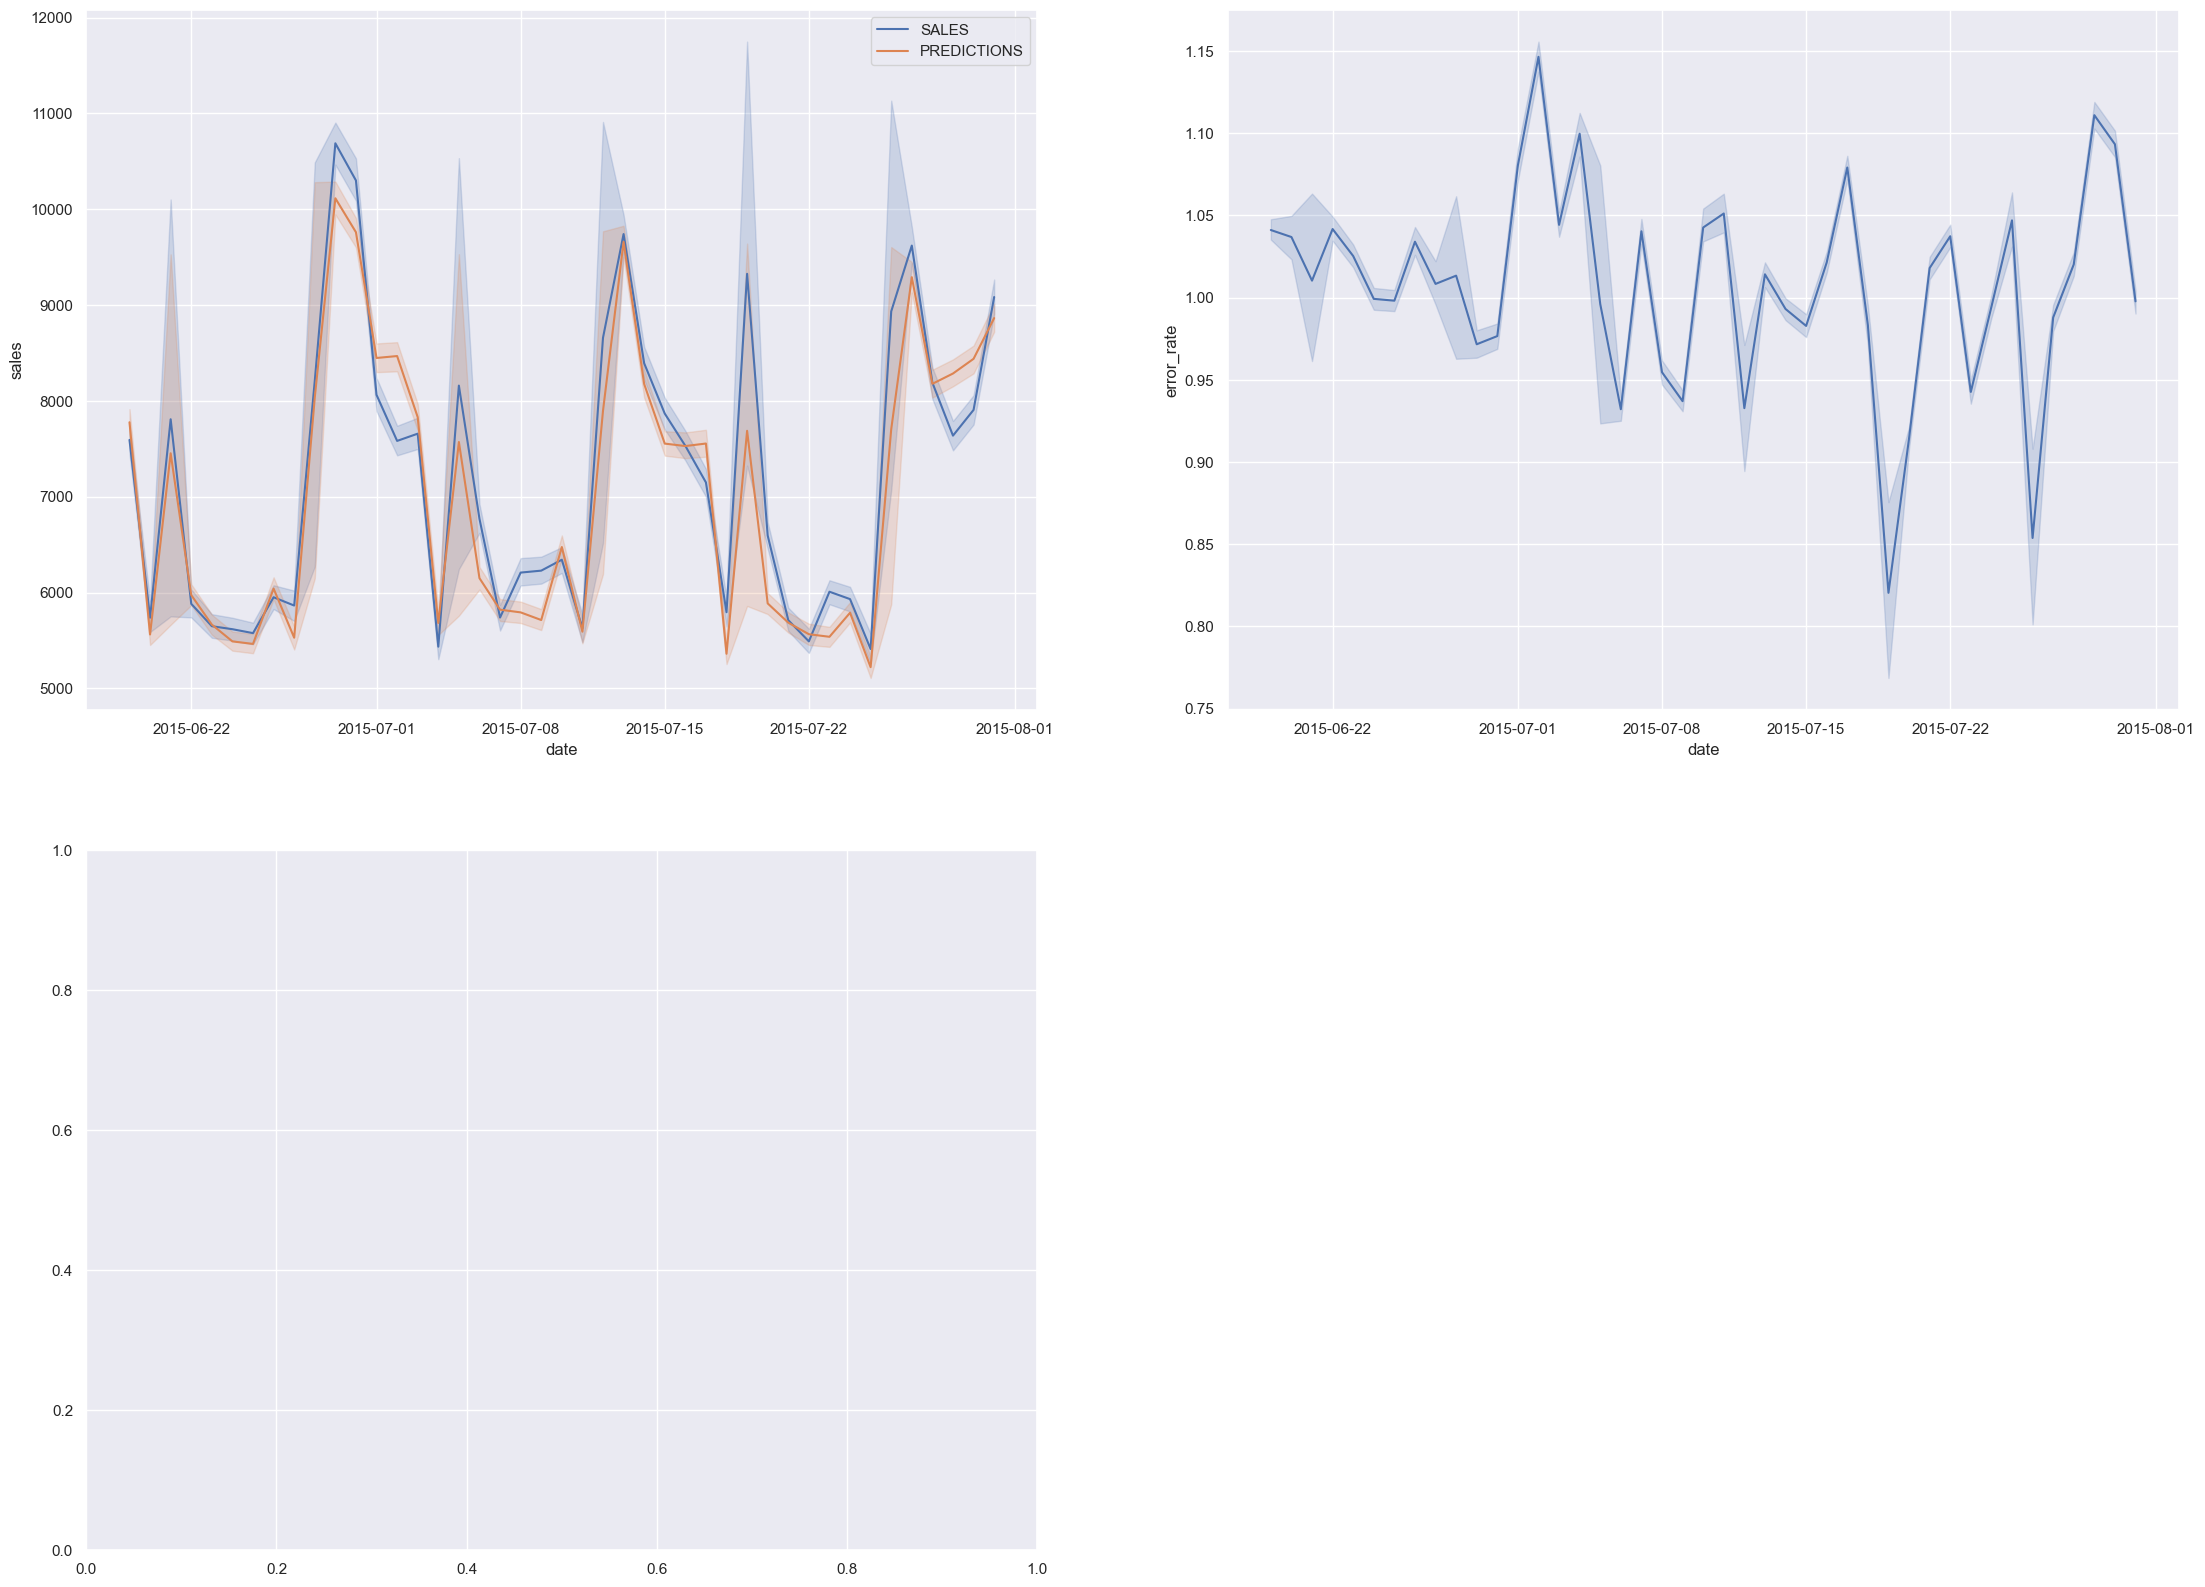

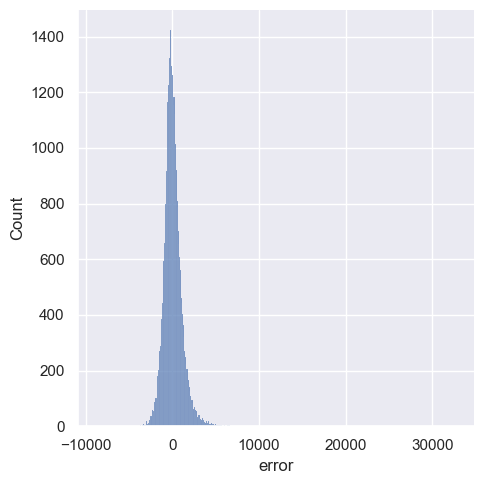

In [115]:
plt.figure(figsize=(27,20))
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(2, 2, 3)
sns.displot(df9['error'])

# 10.0 Passo 10 - Deploy Model to Production

## 10.1. Rossman Class

In [78]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = '/Users/Xcell/OneDrive/comunidade_ds/ds_producao/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):

        ## 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        # Rename
        df1.columns = cols_new

        # Data Types
        df1['date'] = pd.to_datetime(df1['date'])

        ## FillOut NA

        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        # promo2_since_week    
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        # promo2_since_year   
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # promo_interval                  
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                   if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## Change Types
        
        # competition_open_since
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int64)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int64) 
        
        # promo
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int64) 
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int64)

        return df1

    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x : datetime.datetime(year = x['competition_open_since_year'], 
                                     month=x['competition_open_since_month'], 
                                     day=1), axis=1)

        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int64)

        # promo since
        df2['promo_since'] = df2.apply(lambda x: str(x['promo2_since_year']) + '-' + str(x['promo2_since_week']), axis=1)

        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'extra' 
                                                          if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        ## Filtragem das Linhas
        df2 = df2[(df2['open'] != 0)]

        ## Seleção das Colunas
        cols_drop =  ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
        
    def data_preparation(self, df5):

        # Rescaling

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ### Encoding

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix='state_holiday', columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}

        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### Responde Variable Transformation

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7  ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7  ) ) )

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12  ) ) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12  ) ) )

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52  ) ) )
            
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
                         'competition_open_since_month', 'competition_open_since_year', 'promo2',
                         'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
                         'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 
                         'day_cos', 'week_of_year_sin', 'week_of_year_cos']
            
        return df5[cols_selected]
        
    def get_prediction(self, model, original_data, test_data):
        
        # prediction
        pred = model(test_data)
           
        # juntando a predição com o dataset original    
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', data_format='iso')
        

## 10.2. API Handler

In [61]:
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann
import pandas as pd
import pickle

app = Flask(__name__)

# loading model
model = pickle.load(open('/Users/Xcell/OneDrive/comunidade_ds/ds_producao/model/model_rossmann.pkl','rb'))

@app.route('/rossmann/predict', methods=['POST'])

def rossman_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        
        if isinstance(test_json, dict): # Unique Example
            test_raw = pd.DataFrame(test_json, index=[0])
        
        else: # Multiple Example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # Instaciando a classe rossman
        pipeline = Rossmann()
    
        # data_cleaning
        df1 = pipeline.data_cleaning(test_raw)
    
        # feature_engineering
        df2 = pipeline.feature_engineering(df1)

        # data_preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')
    

if __name__ == '__main__':
    app.run('192.168.1.2')    

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [116]:
# load dos dados de teste
df10 = pd.read_csv('data/test.csv')

In [117]:
# merge do dataset test + df_store_raw
df_test = pd.merge(df10, df_store_raw, how='inner', on='Store')

# escolha de um store para predição
df_test = df_test[df_test['Store'] == 22]

# removendo os dias em que a loja está fechada.
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop(columns='Id', axis=1)

In [118]:
# convert Dataframe to json
data = json.dumps(df_test.to_dict( orient='records'))

In [119]:
# Api Call
url    = 'https://app-rossmann-prediction.herokuapp.com/rossmann/predict'
header = {'Content-type':'application/json'}
data   = data

r = requests.post(url, data = data, headers=header)

print('Status Code: {}'.format(r.status_code))

Status Code: 200


In [120]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

print('A loja {} vai vender nas próximas 6 semanas R$ {:,.2f}'.format(d2['store'].values[0], d2['prediction'].values[0]))

A loja 22 vai vender nas próximas 6 semanas R$ 164,104.84
